In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm_notebook as tqdm
from torch.optim import SGD
from torch.optim.lr_scheduler import (
    CosineAnnealingLR, CosineAnnealingWarmRestarts, CyclicLR, ExponentialLR,
    LambdaLR, MultiStepLR, OneCycleLR, ReduceLROnPlateau, StepLR
)
from torchvision.models import resnet18
sns.set()
warnings.filterwarnings('ignore')

In [4]:
def plot_images(imgs, names=None, axs=None, show=True, nrows=None, ncols=None, figsize=(16, 8), filename='out'):
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    from math import ceil
    if nrows is None and ncols is None:
        nrows = 1
        ncols = len(imgs)
    elif nrows is None:
        nrows = ceil(len(imgs) / ncols)
    elif ncols is None:
        ncols = ceil(len(imgs) / nrows)
    
    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0])
        axs.set_axis_off()
        if names and len(names) > 0:
            axs.set_title(names[0], fontsize=15)
    elif nrows == 1 or ncols == 1:
        for j, ax in enumerate(axs):
            ax.imshow(imgs[j])
            ax.set_axis_off()
            if names and j < len(names):
                ax.set_title(names[j], fontsize=15)
    else:
        for j, ax in enumerate(axs):
            for k, sub_ax in enumerate(ax):
                image_id = j * ncols + k
                sub_ax.set_axis_off()
                if image_id < len(imgs):
                    sub_ax.imshow(imgs[image_id])
                    if names and image_id < len(names):
                        sub_ax.set_title(names[image_id], fontsize=15)
    if show:
        plt.show()
        
def check_scheduler(scheduler_class, lr=0.01, num_epochs=100, num_batches=None, **scheduler_params):
    model = resnet18()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = scheduler_class(optimizer, **scheduler_params)
    lrs = [optimizer.param_groups[0]['lr']]
    for epoch in range(num_epochs):
        if num_batches is not None:
            for batch in range(num_batches):
                scheduler.step()
                lrs.append(optimizer.param_groups[0]['lr'])
        else:
            scheduler.step()
            lrs.append(optimizer.param_groups[0]['lr'])
    lrs = np.array(lrs)
    x = np.arange(len(lrs))
    x = x / (1 if num_batches is None else num_batches)
    
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5), dpi=300)

    plt.suptitle('Lerning rates for ' + str(scheduler_class)[33:-2])
    plt.subplot(121)
    plt.xlabel("Number of epoch")
    plt.ylabel("Learning Rate")
    plt.plot(x, lrs)

    plt.subplot(122)
    plt.xlabel("Number of epoch")
    plt.ylabel("Learning Rate")
    plt.yscale("log")
    plt.plot(x, lrs)

    plt.show()
    
def check_stack_schedulers(schedulers_params, num_epochs=100, num_batches=1000, lr=0.01):
    model = resnet18()
    optimizer = SGD(model.parameters(), lr=lr)
    schedulers_batch = []
    schedulers_epoch = []
    names = []
    batch_wise = False
    for scheduler_params in schedulers_params:
        scheduler_class = scheduler_params['name']
        params = scheduler_params['params']
        names.append(str(scheduler_class)[33:-2])
        scheduler = scheduler_class(optimizer, **params)
        if isinstance(scheduler, (CyclicLR, OneCycleLR)):
            schedulers_batch.append(scheduler)
            batch_wise = True
        else:
            schedulers_epoch.append(scheduler)
    lrs = [optimizer.param_groups[0]['lr']]
    for epoch in range(num_epochs):
        if batch_wise:
            for batch in range(num_batches):
                for scheduler in schedulers_batch:
                    scheduler.step()
                lrs.append(optimizer.param_groups[0]['lr'])
                
        for scheduler in schedulers_epoch:
            scheduler.step()
        if not batch_wise:
            lrs.append(optimizer.param_groups[0]['lr'])
            
    lrs = np.array(lrs)
    x = np.arange(len(lrs))
    x = x / (num_batches if batch_wise else 1)
    
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5), dpi=300)

    plt.suptitle('Lerning rates for ' + " + ".join(names))
    plt.subplot(121)
    plt.xlabel("Number of epoch")
    plt.ylabel("Learning Rate")
    plt.plot(x, lrs)

    plt.subplot(122)
    plt.xlabel("Number of epoch")
    plt.ylabel("Learning Rate")
    plt.yscale("log")
    plt.plot(x, lrs)

    plt.show()
    

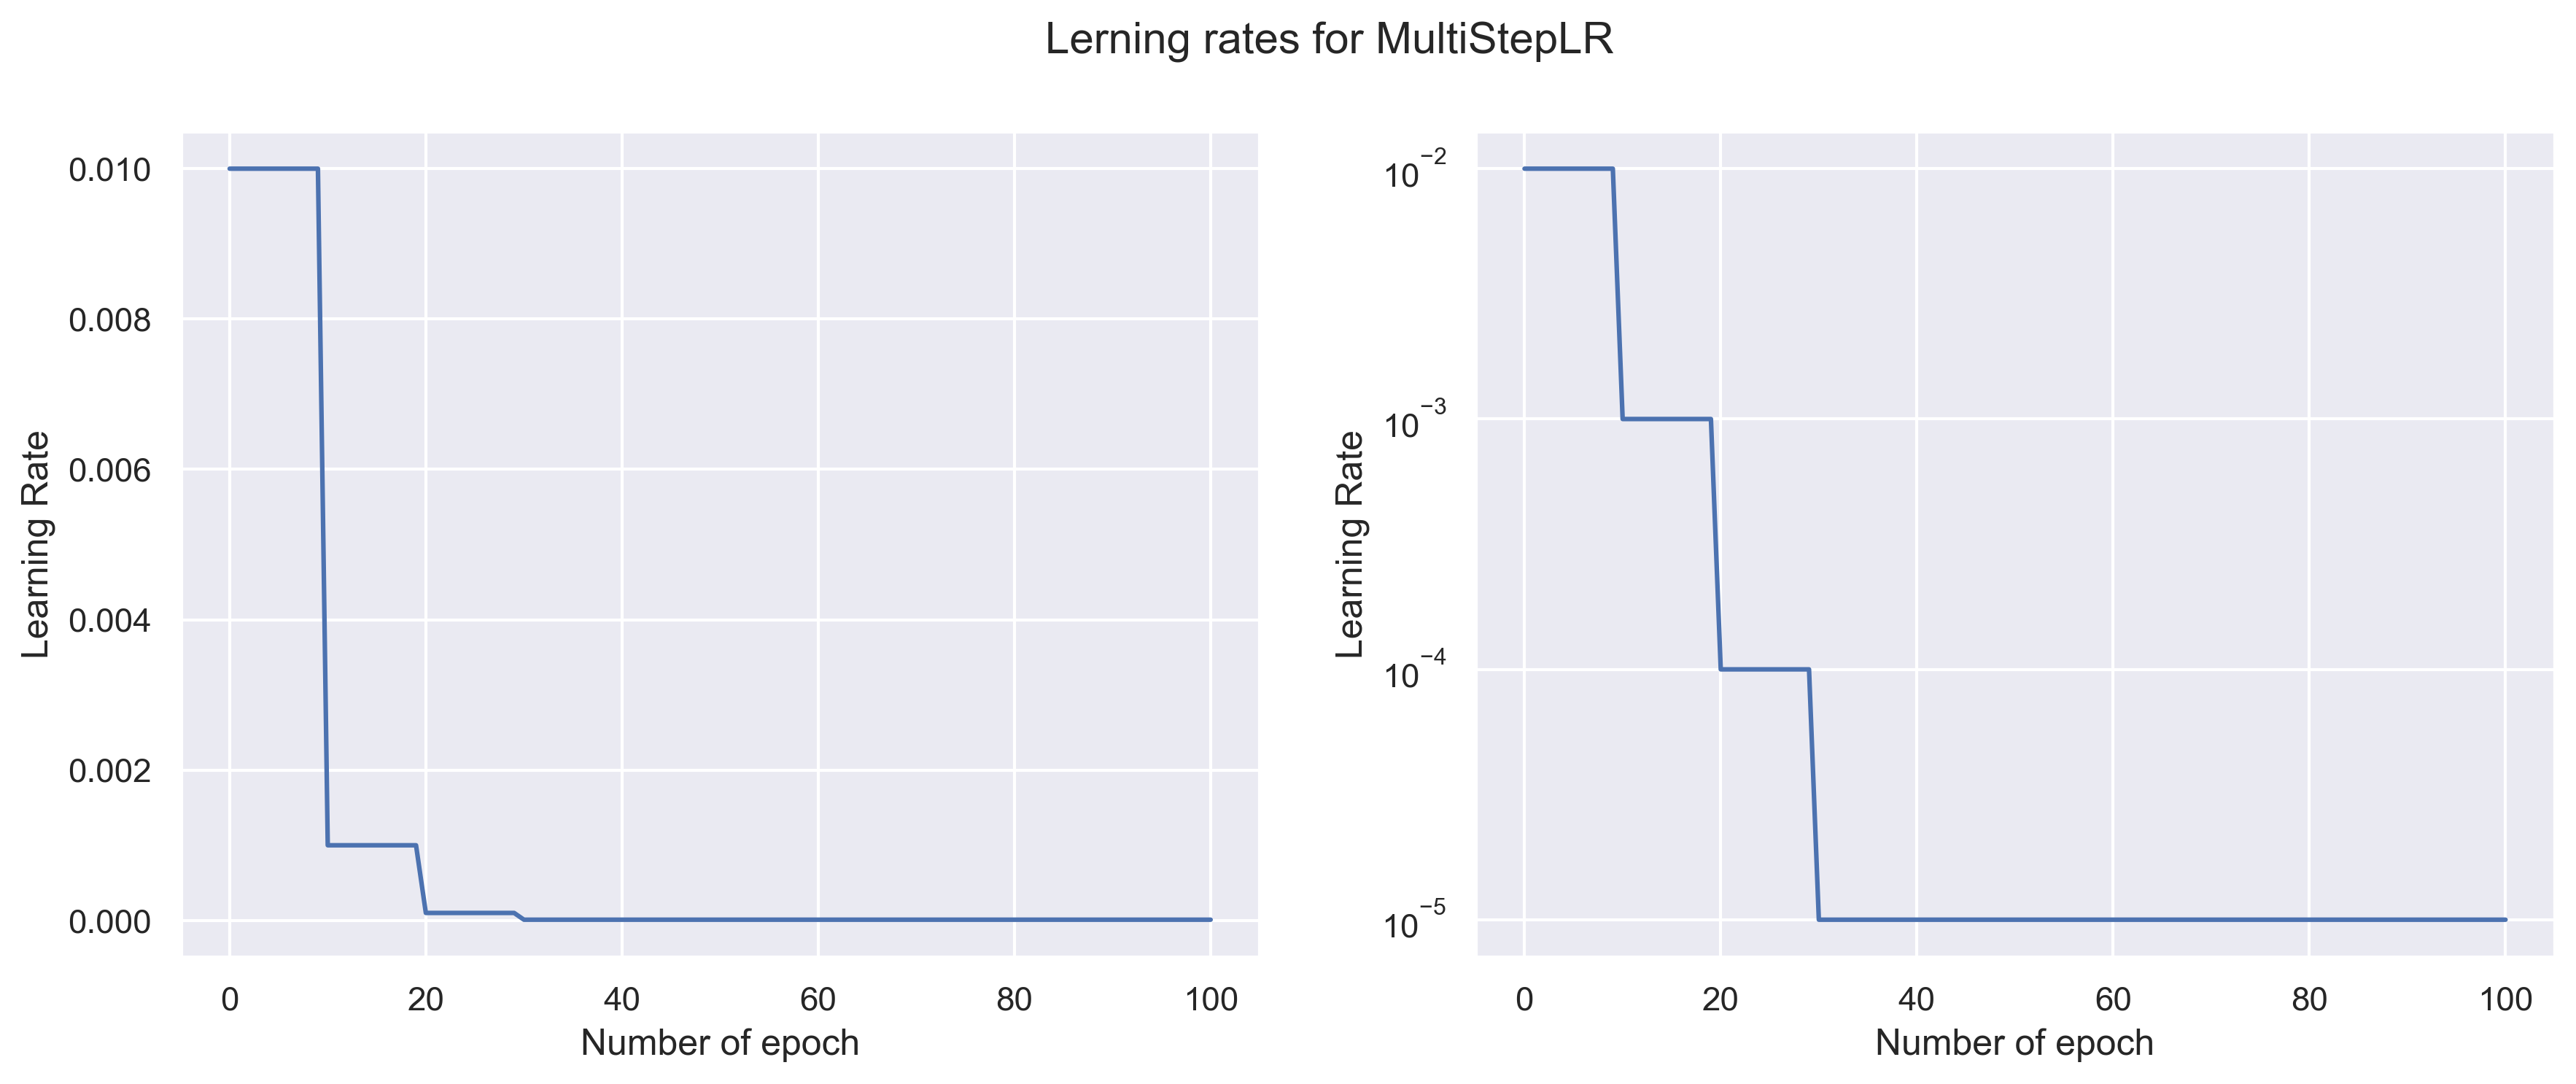

In [3]:
check_scheduler(MultiStepLR, 100, milestones=[10, 20, 30])

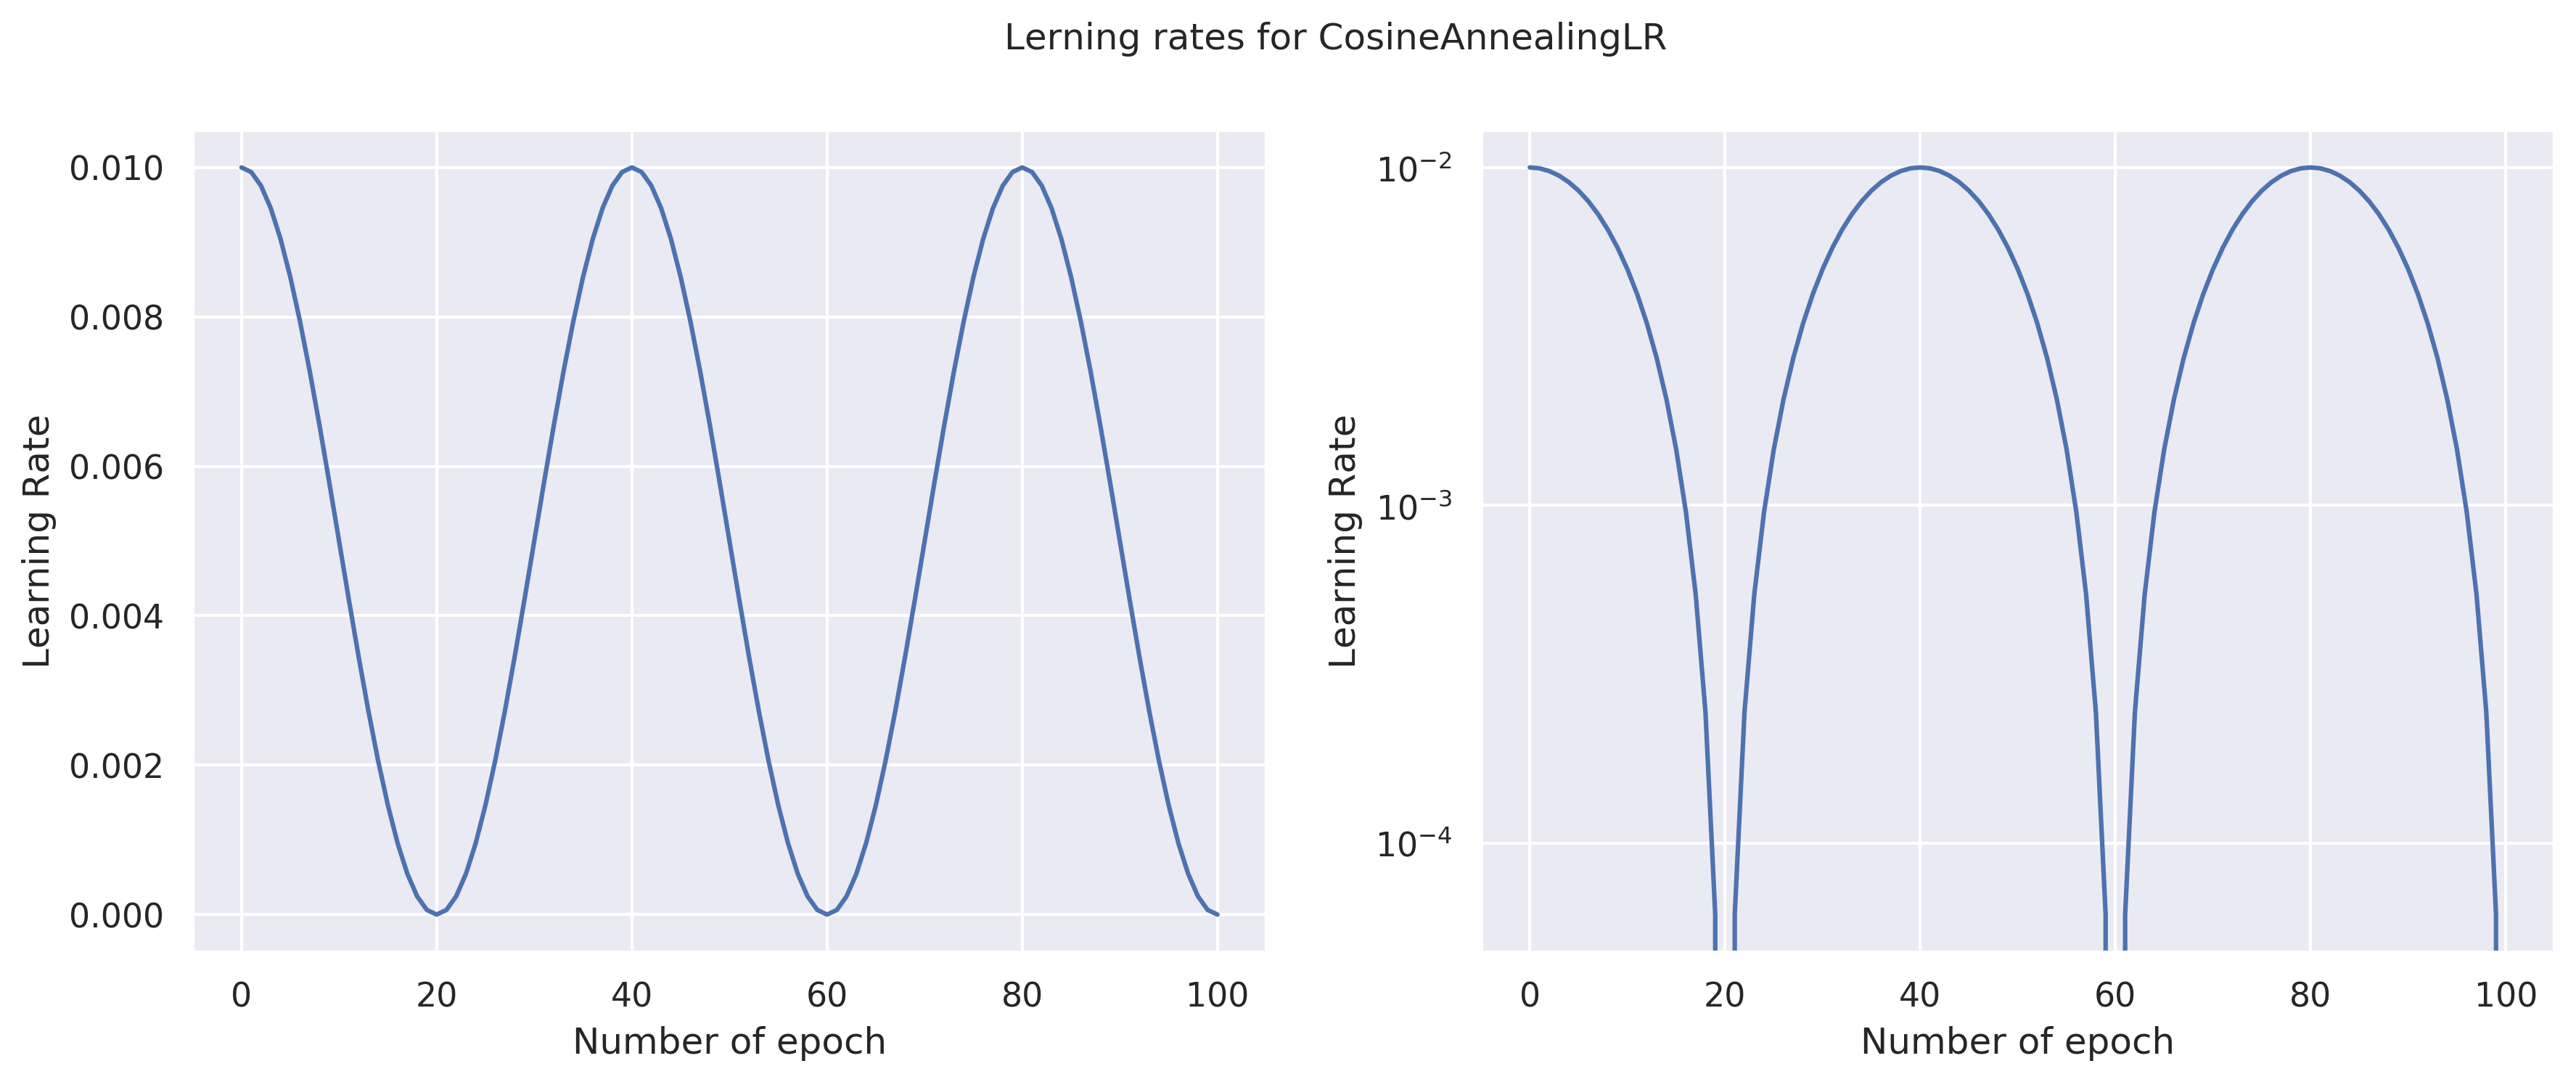

In [4]:
check_scheduler(CosineAnnealingLR, 100, T_max=20)

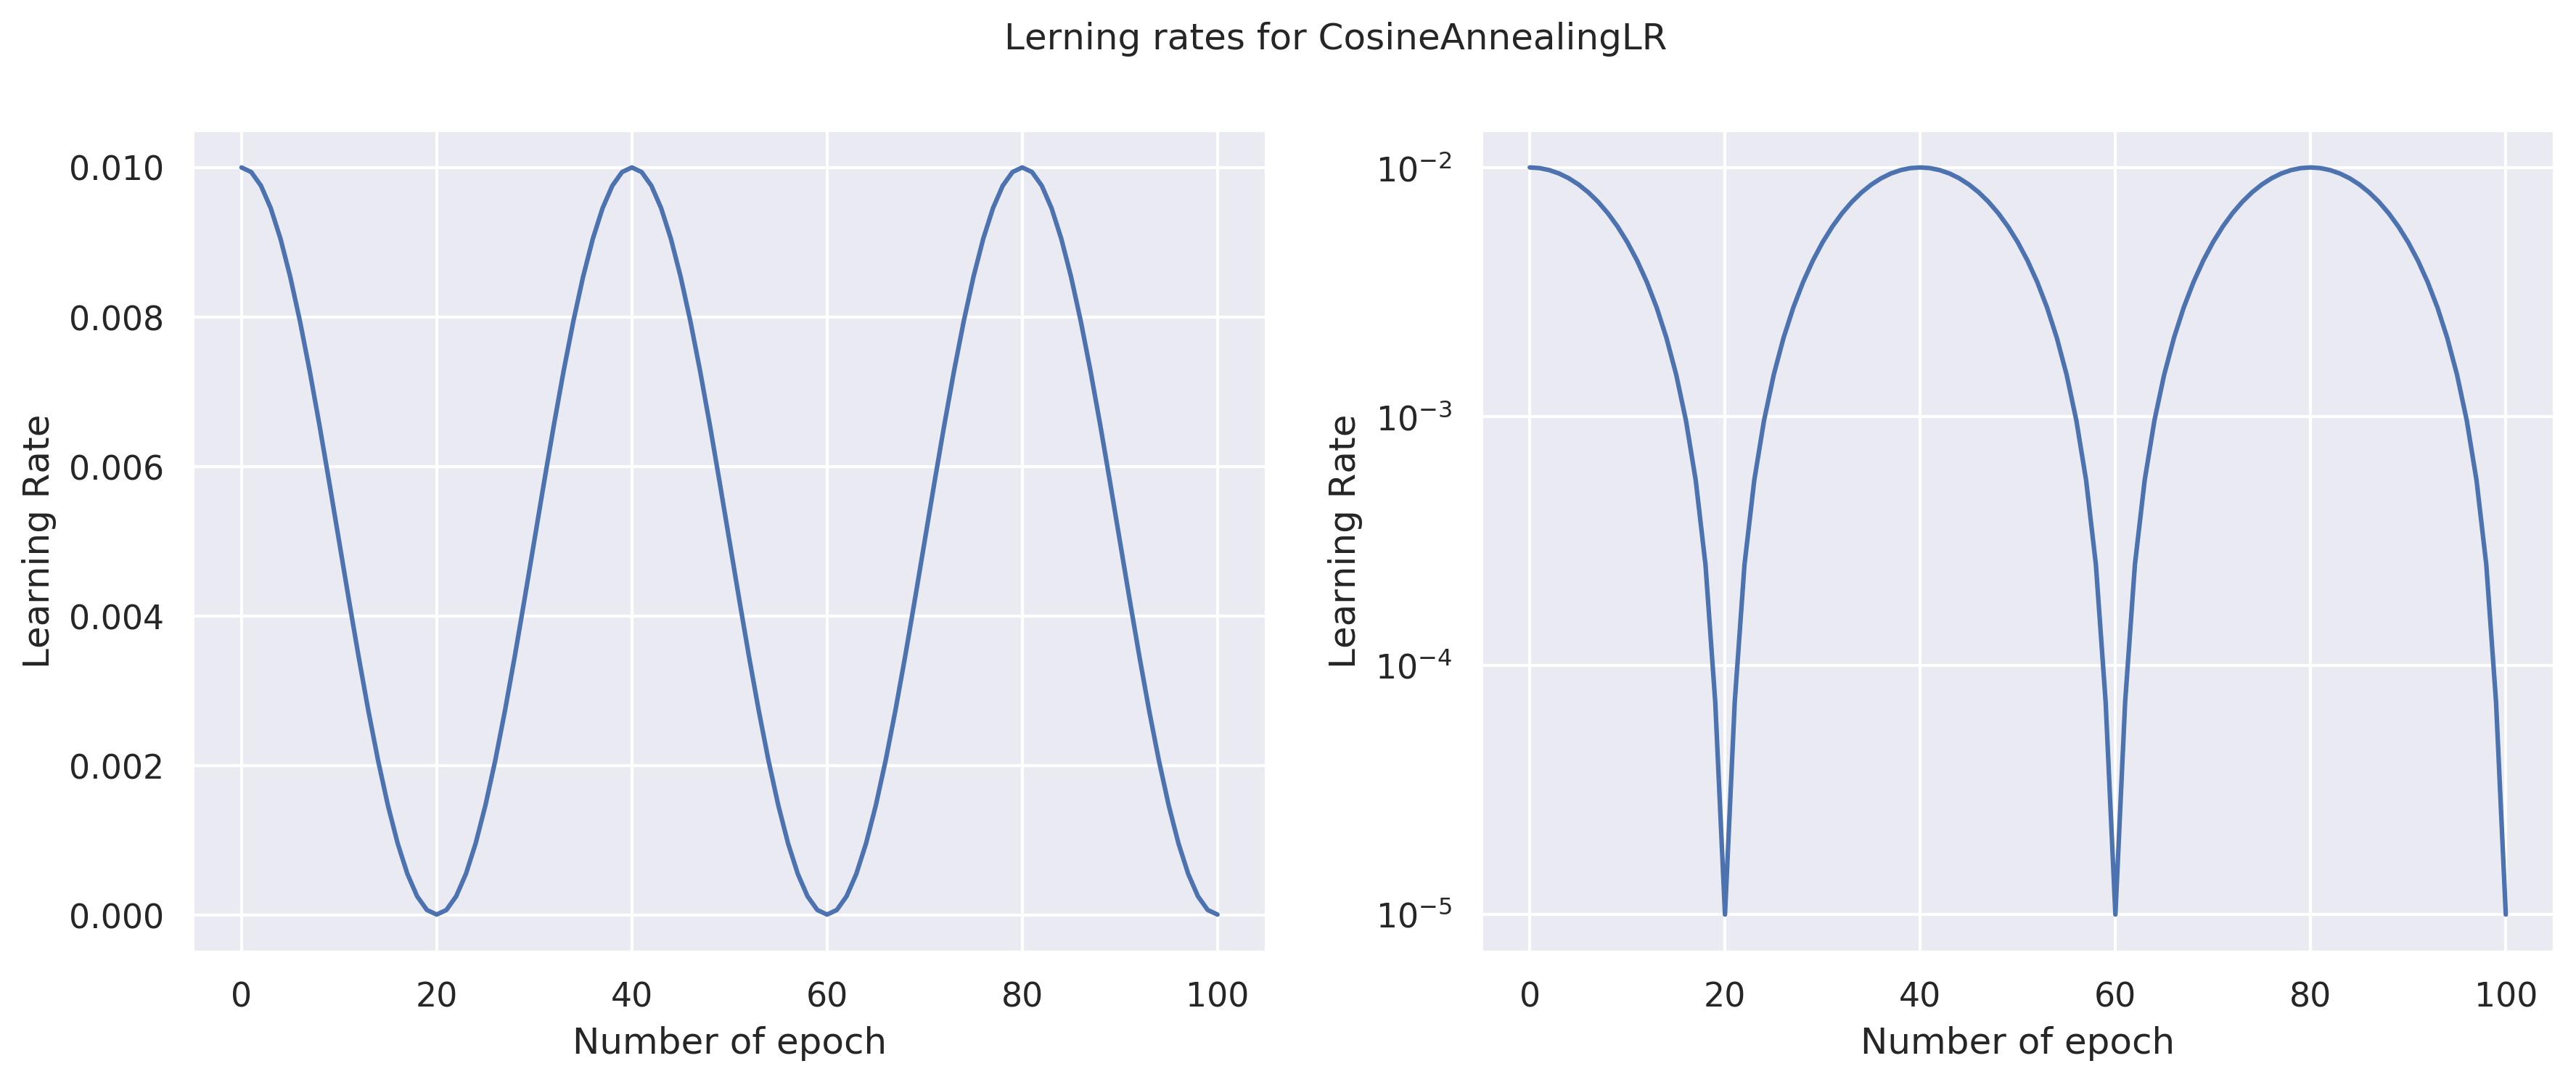

In [5]:
check_scheduler(CosineAnnealingLR, 100, T_max=20, eta_min=1e-5)

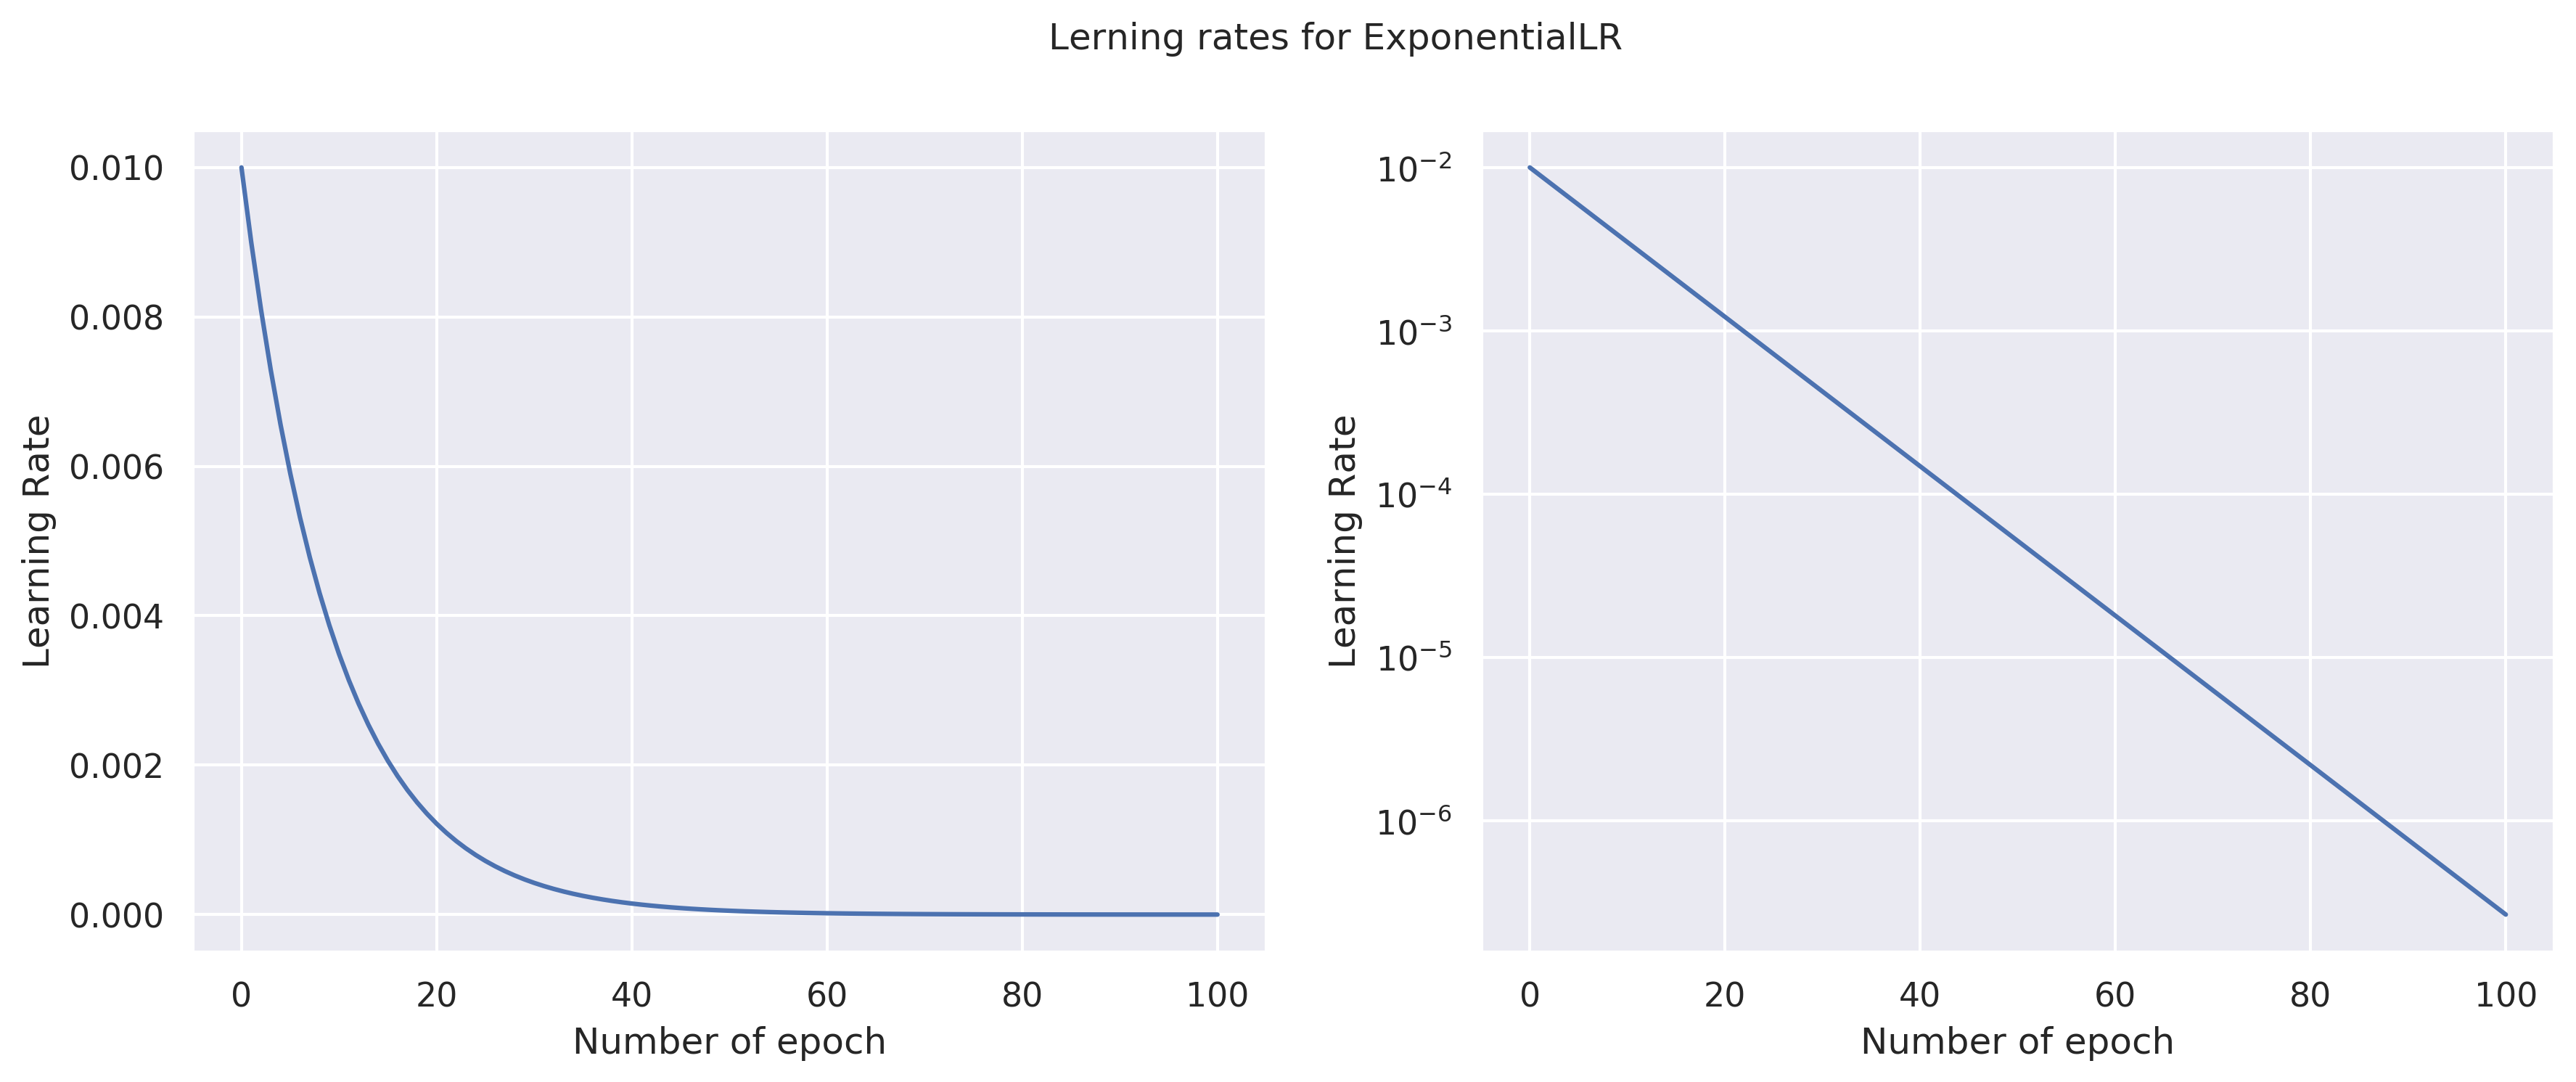

In [6]:
check_scheduler(ExponentialLR, 100, gamma=0.9)

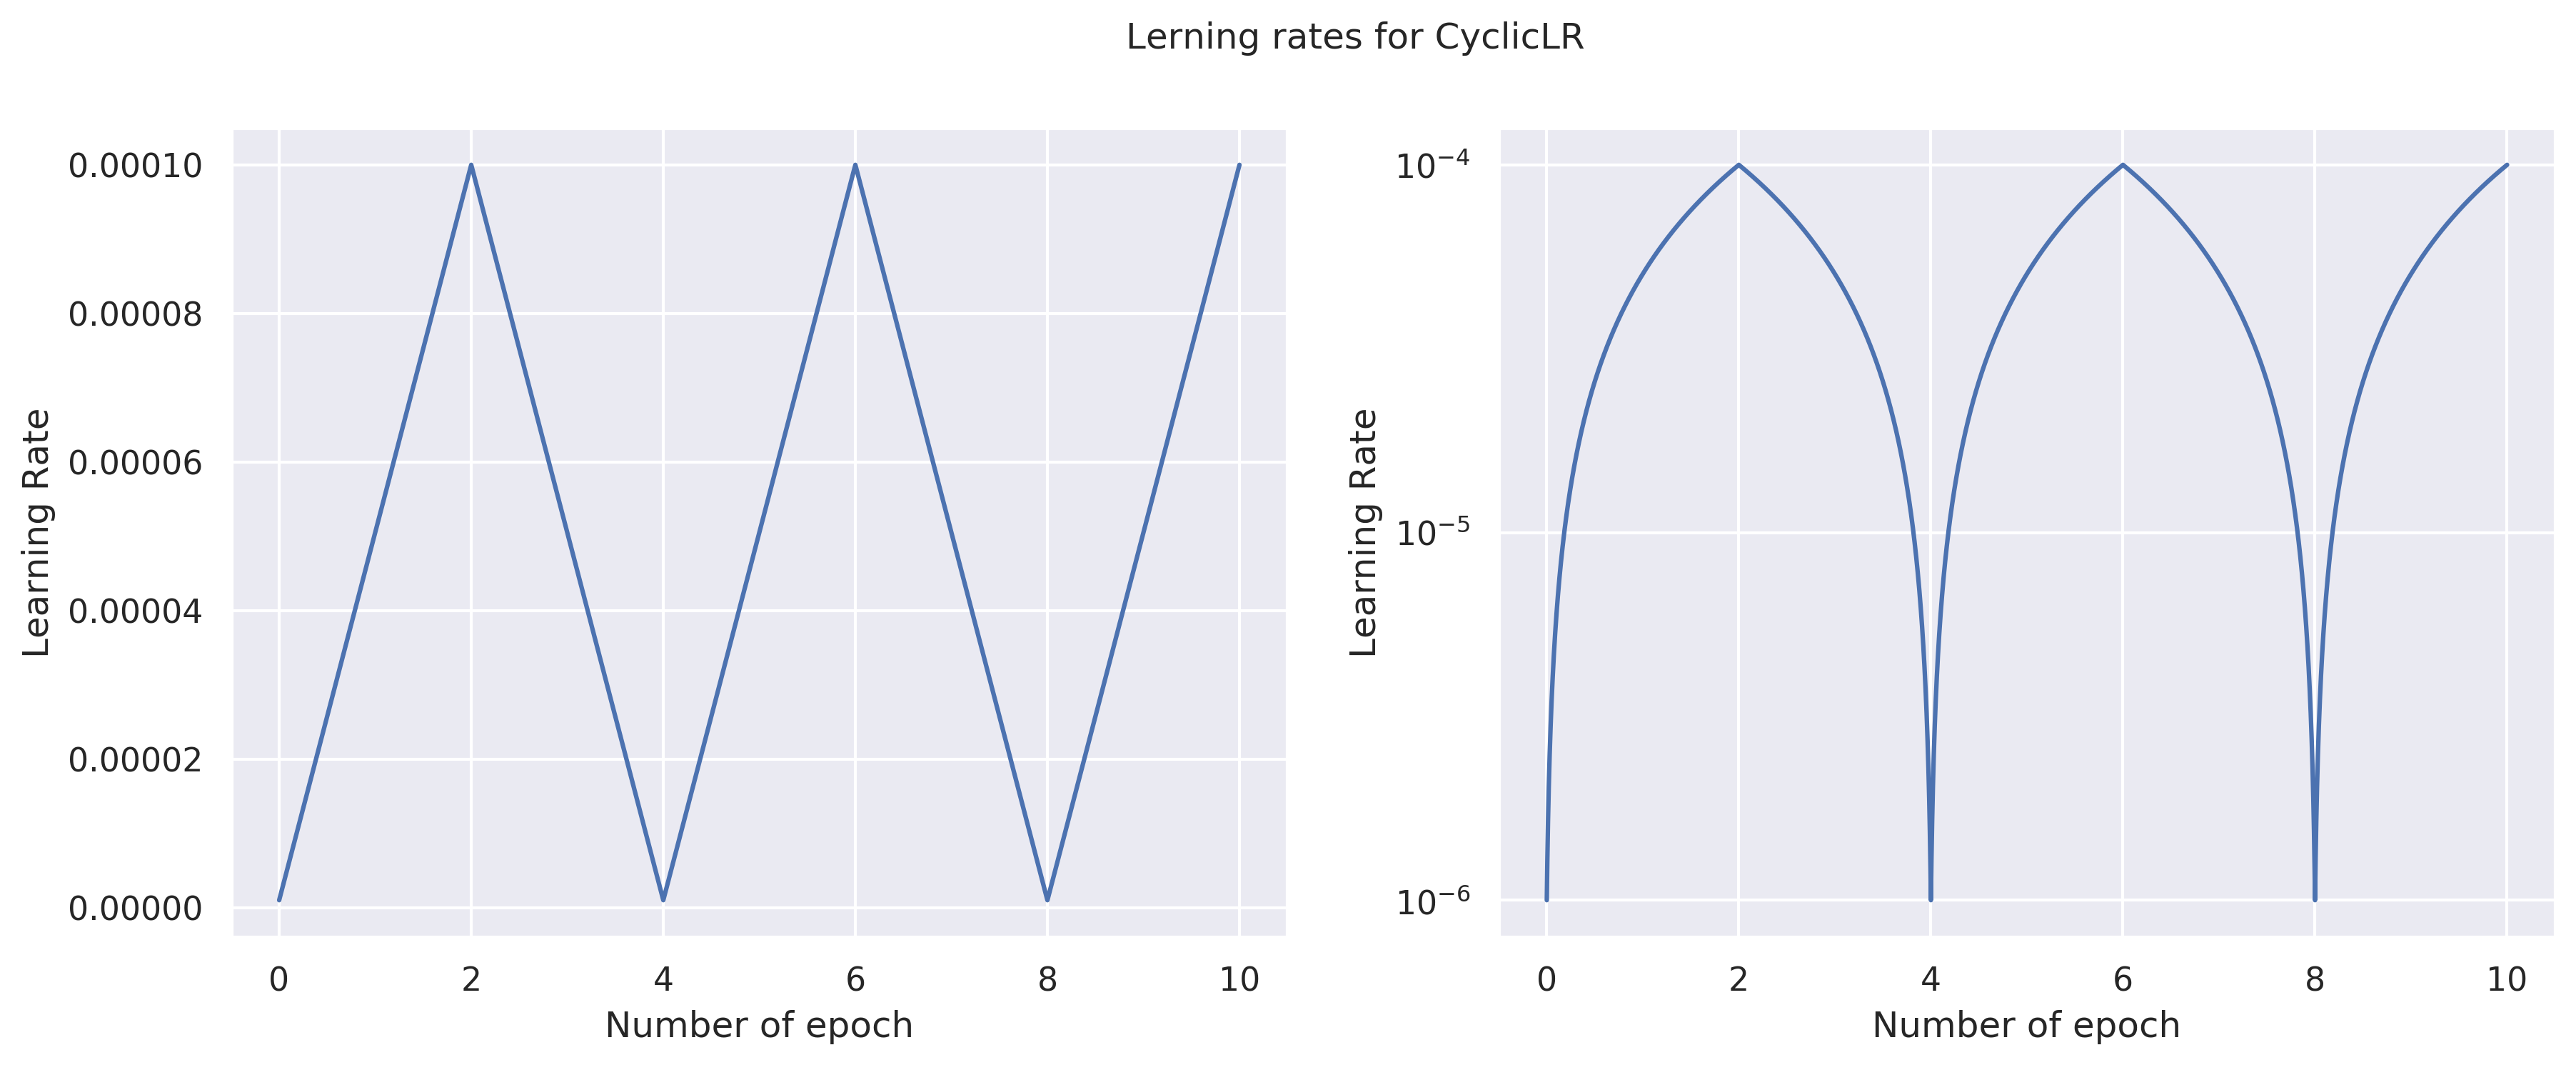

In [7]:
check_scheduler(CyclicLR(, 10, num_batches=1000, 
                base_lr=1e-6, max_lr=1e-4, step_size_up=2000, gamma=0.9)

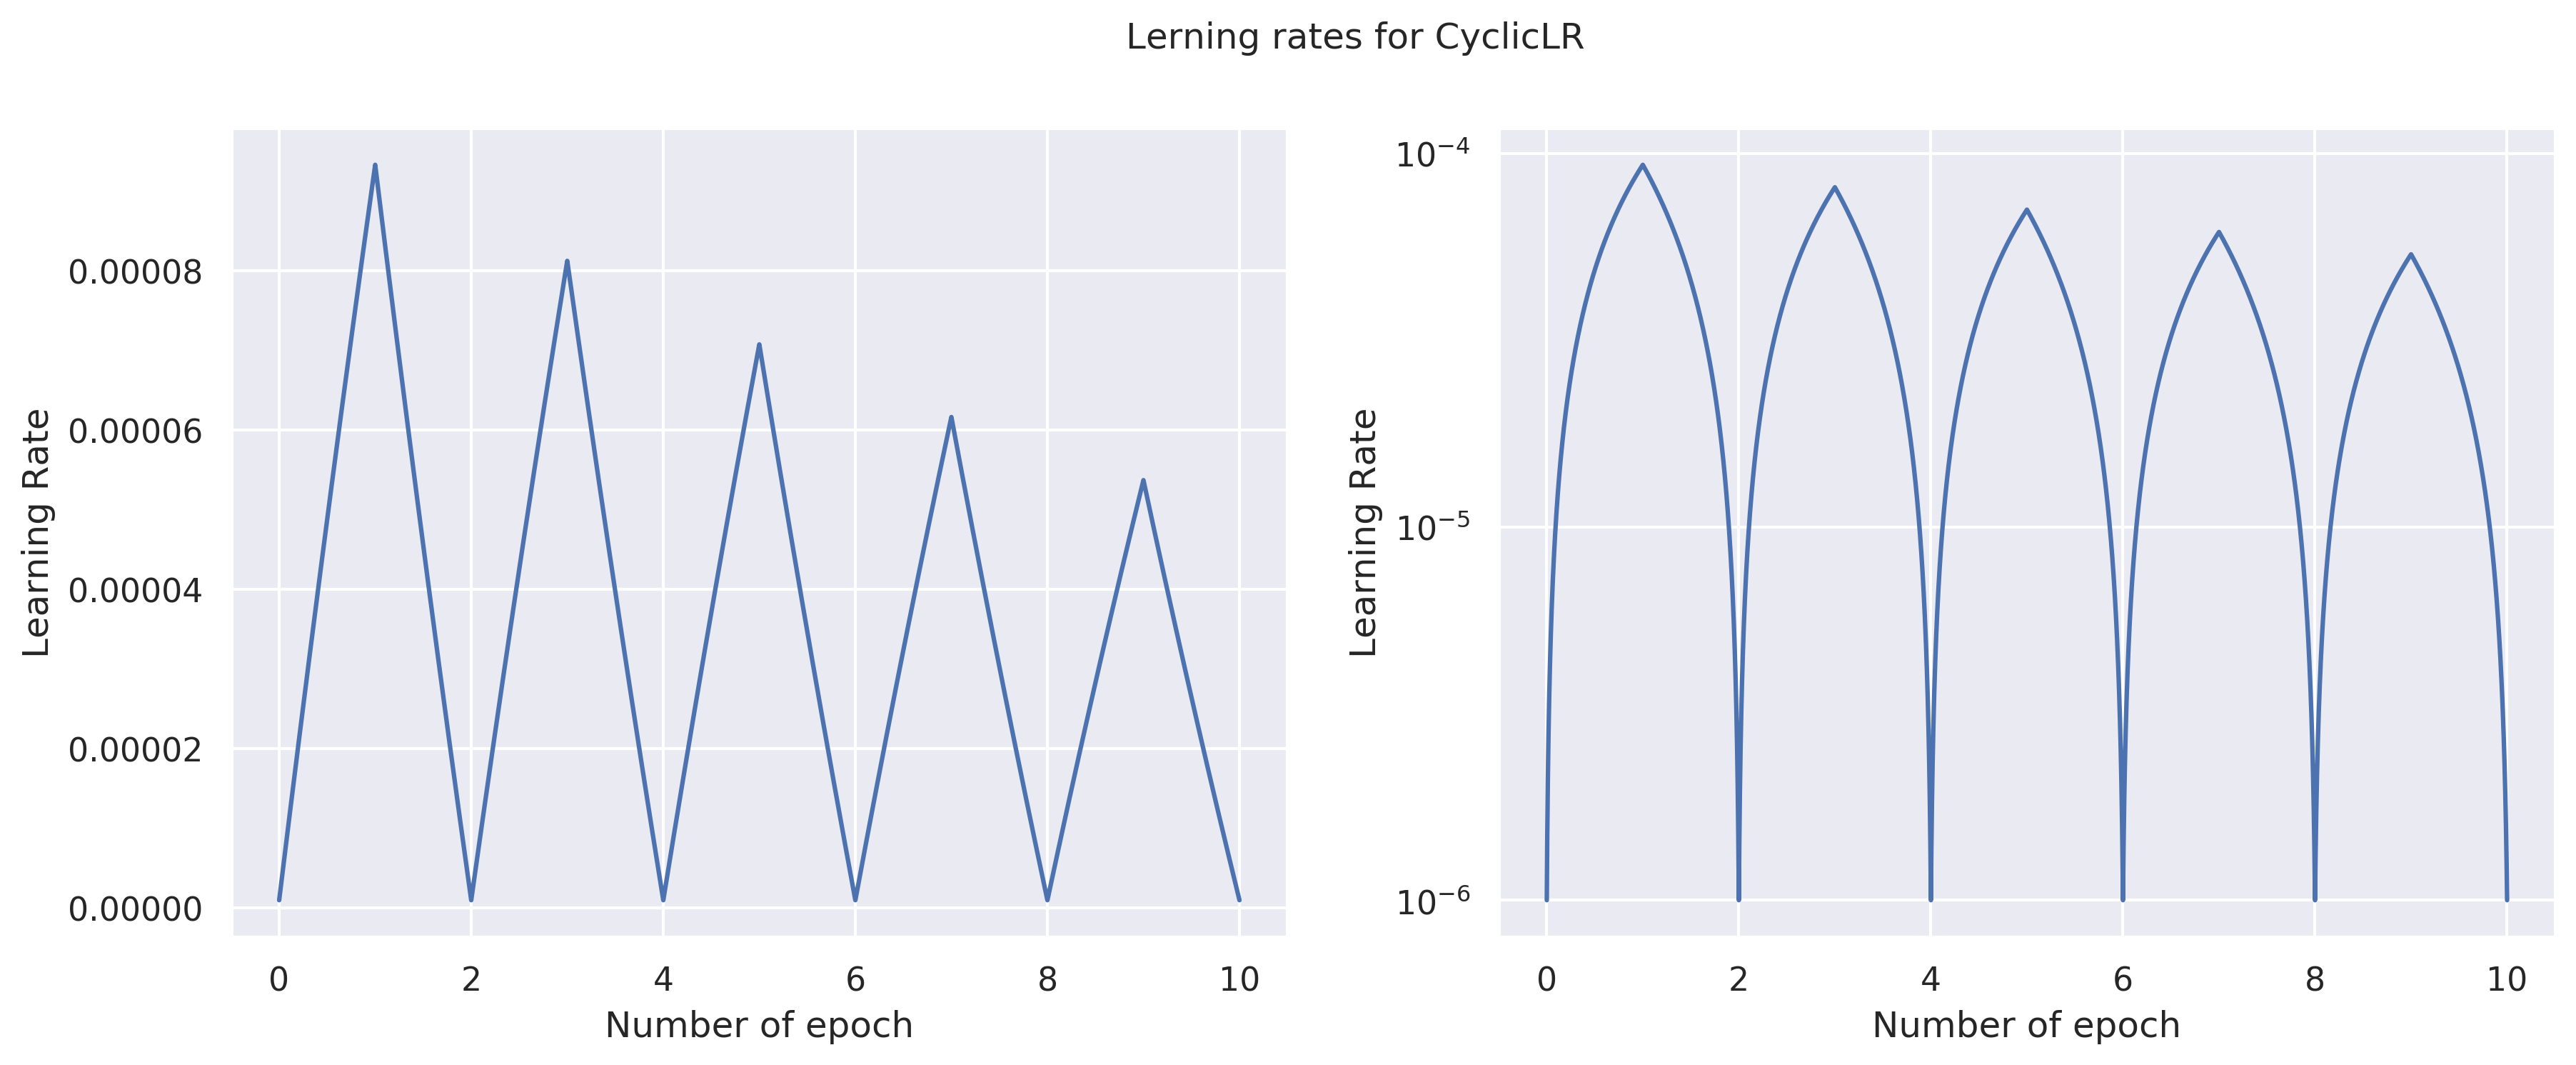

In [8]:
check_scheduler(CyclicLR, 10, num_batches=1000, 
                base_lr=1e-6, max_lr=1e-4, step_size_up=1000, gamma=0.99993,  mode='exp_range')

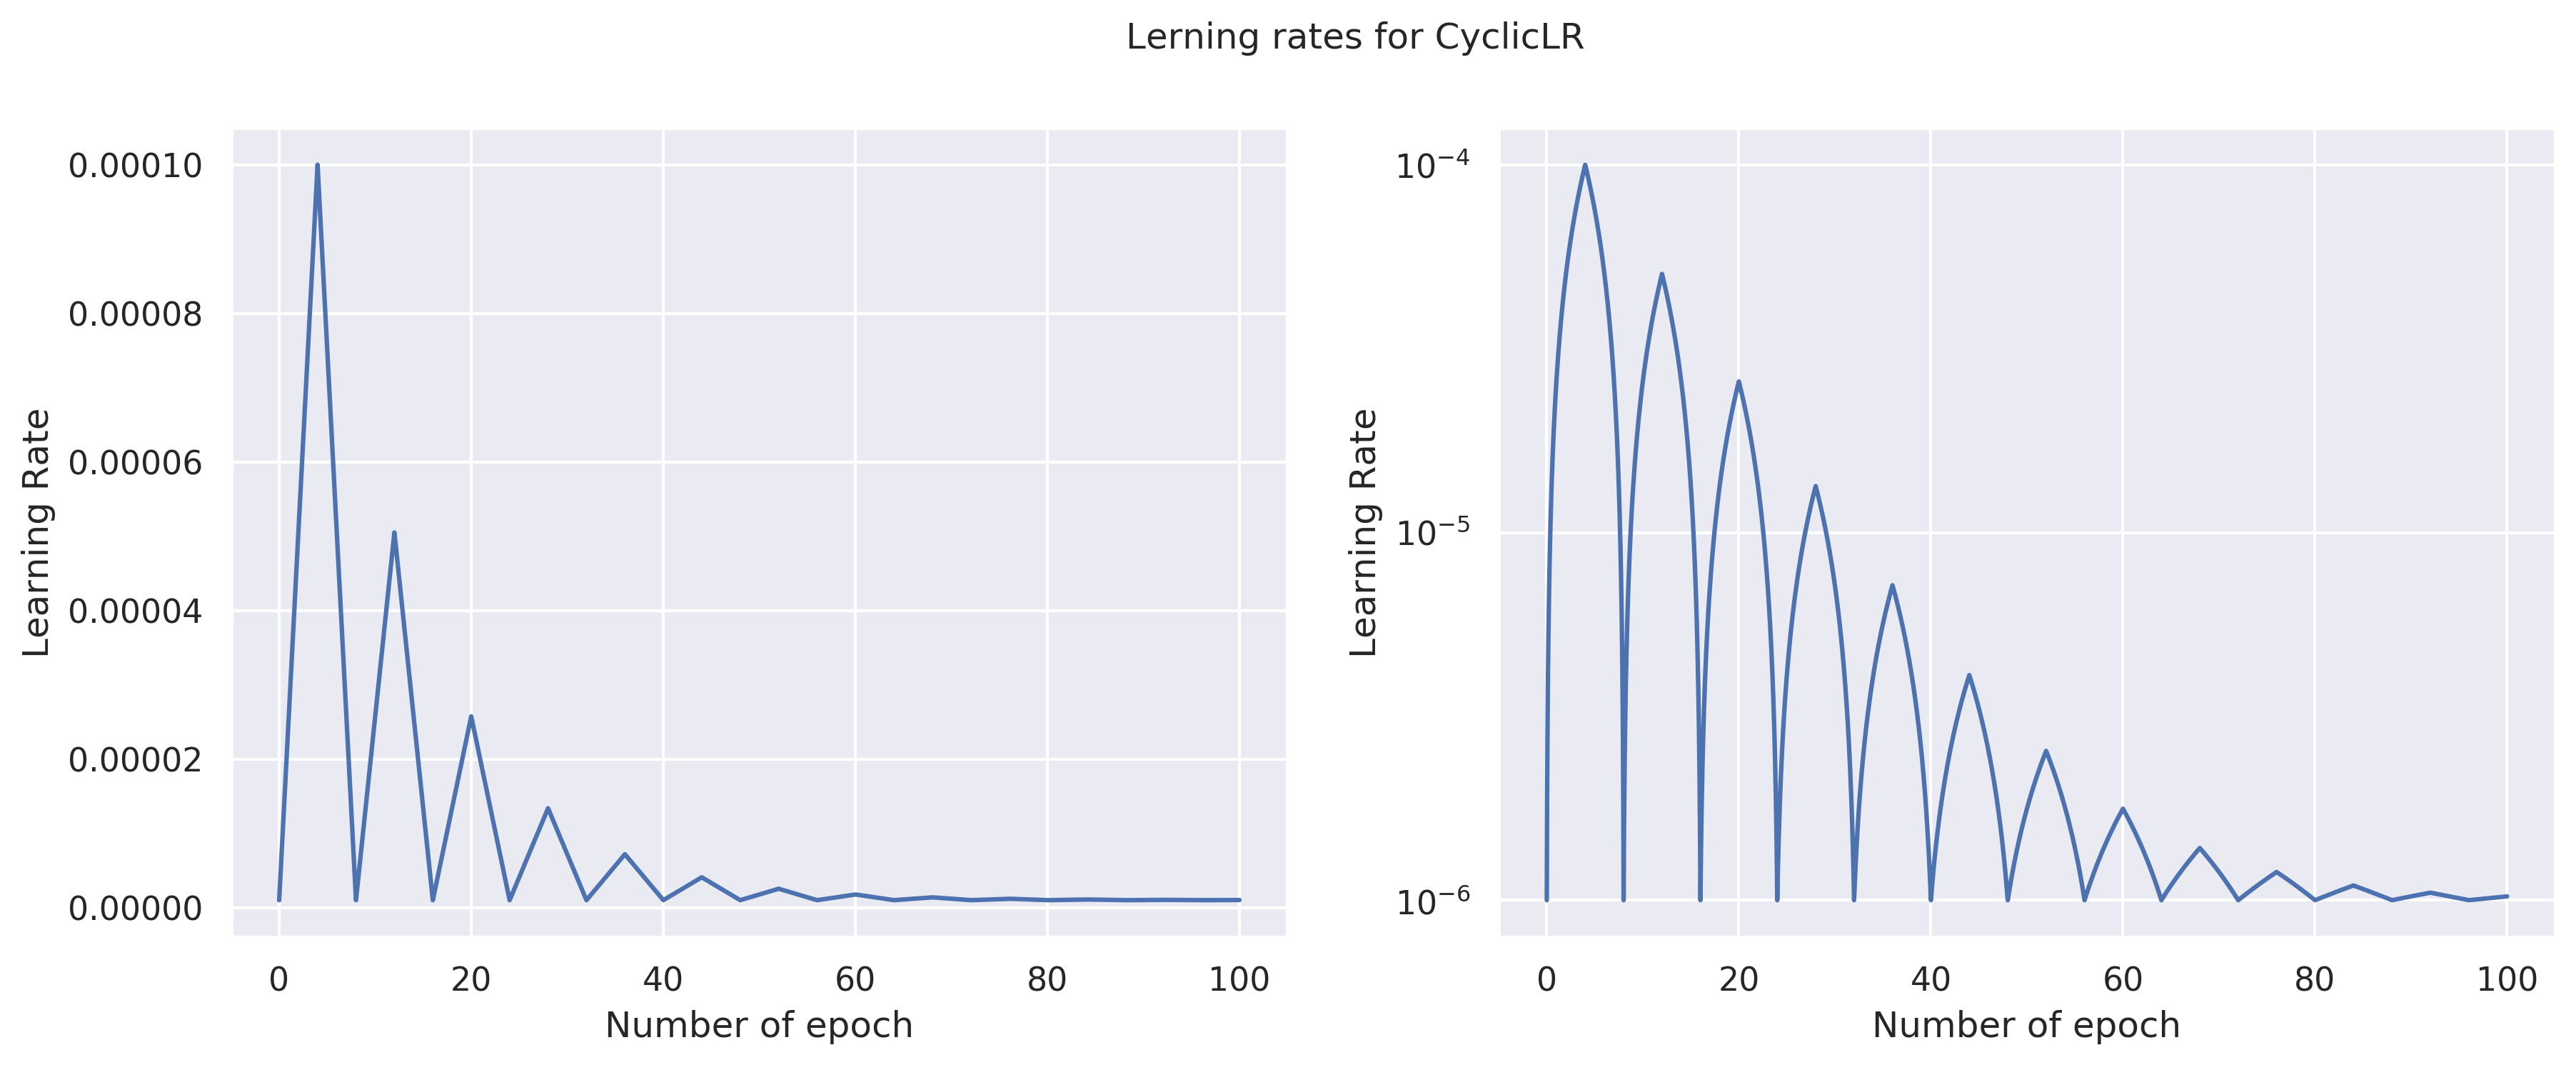

In [9]:
check_scheduler(CyclicLR, 100, num_batches=1000, 
                base_lr=1e-6, max_lr=1e-4, step_size_up=4000,  mode='triangular2')

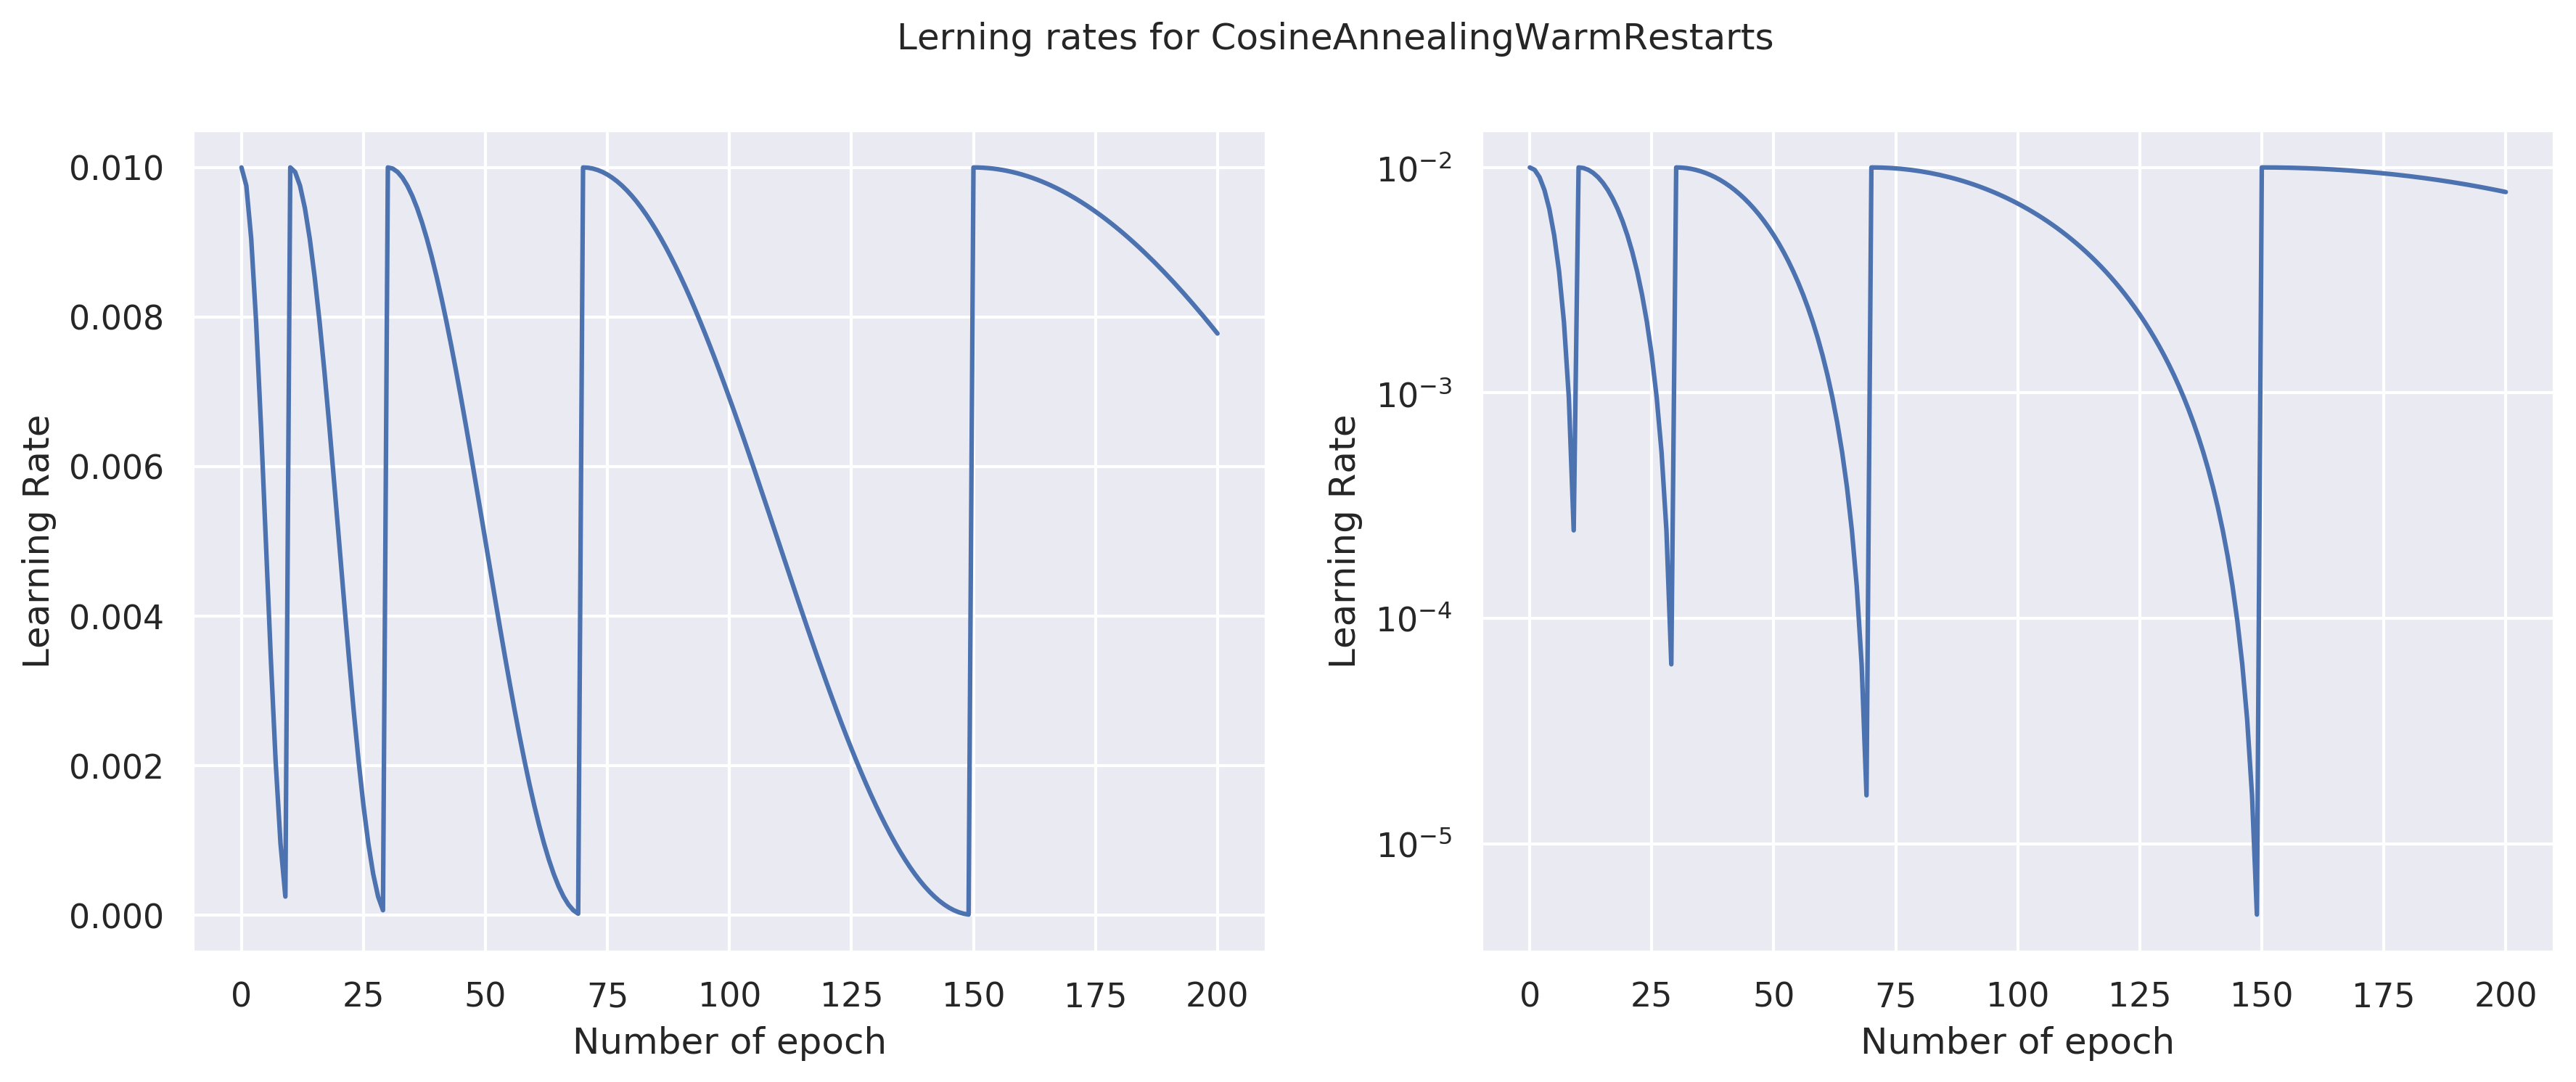

In [11]:
# CosineAnnealingWarmRestarts()
check_scheduler(CosineAnnealingWarmRestarts, 200, #num_batches=1000, 
                T_0=10, T_mult=2, eta_min=1e-6)

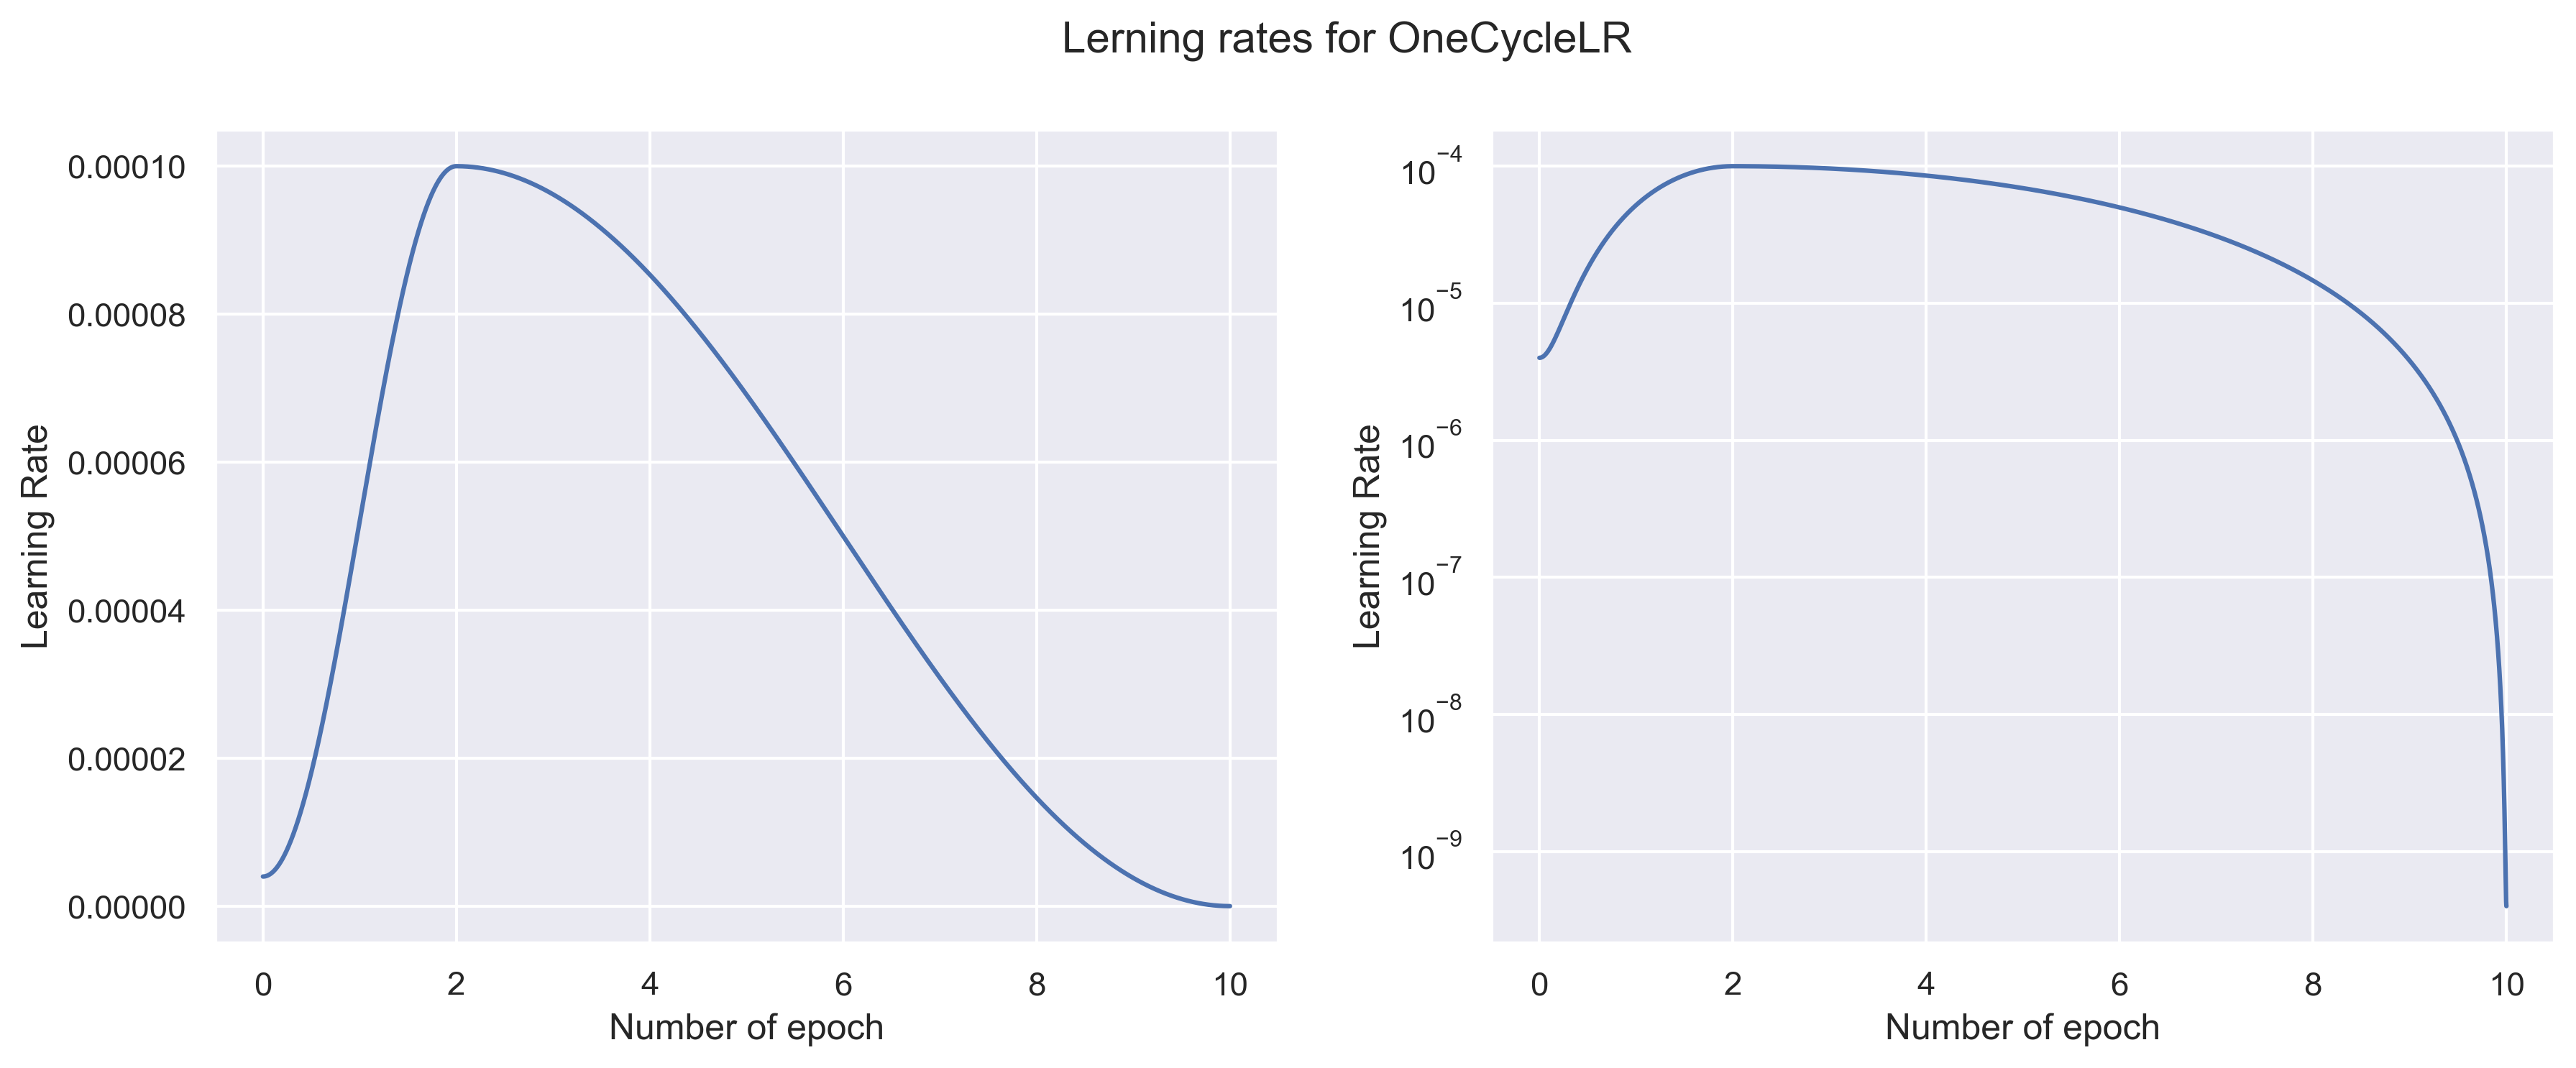

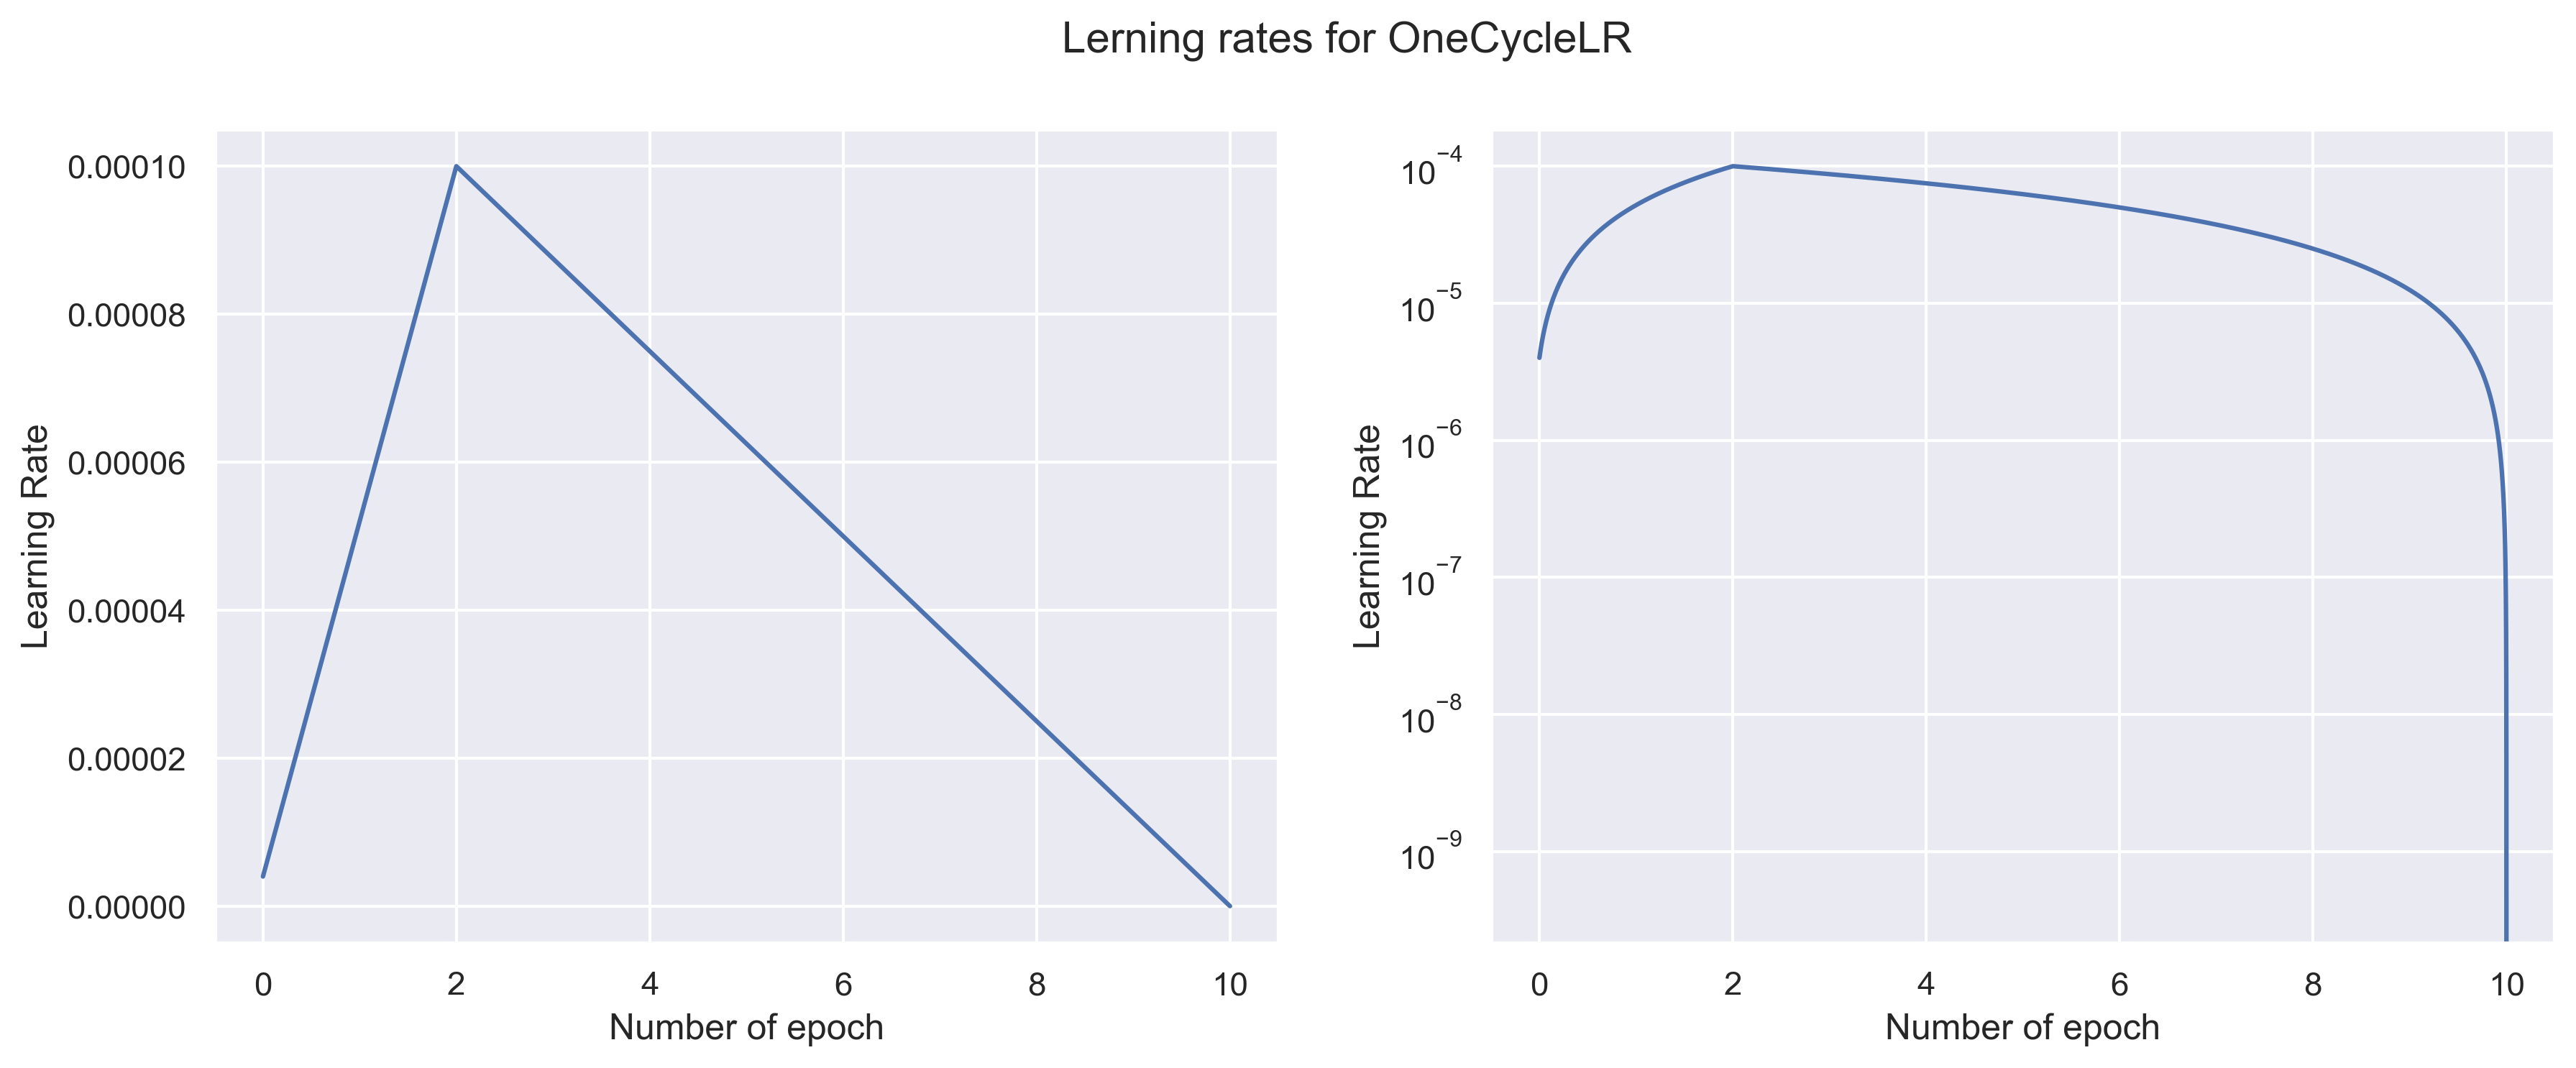

In [7]:
# OneCycleLR()
pct_start=0.2
# cycle_momentum=True,
# base_momentum=0.85,
# max_momentum=0.95,
# div_factor=25.0,
# final_div_factor=10000.0
lr = 0.0001
for strategy in ('cos', 'linear'):
    check_scheduler(OneCycleLR, lr, 10, num_batches=8000, 
                    max_lr=lr, epochs=10, steps_per_epoch=8000, pct_start=pct_start, anneal_strategy=strategy)

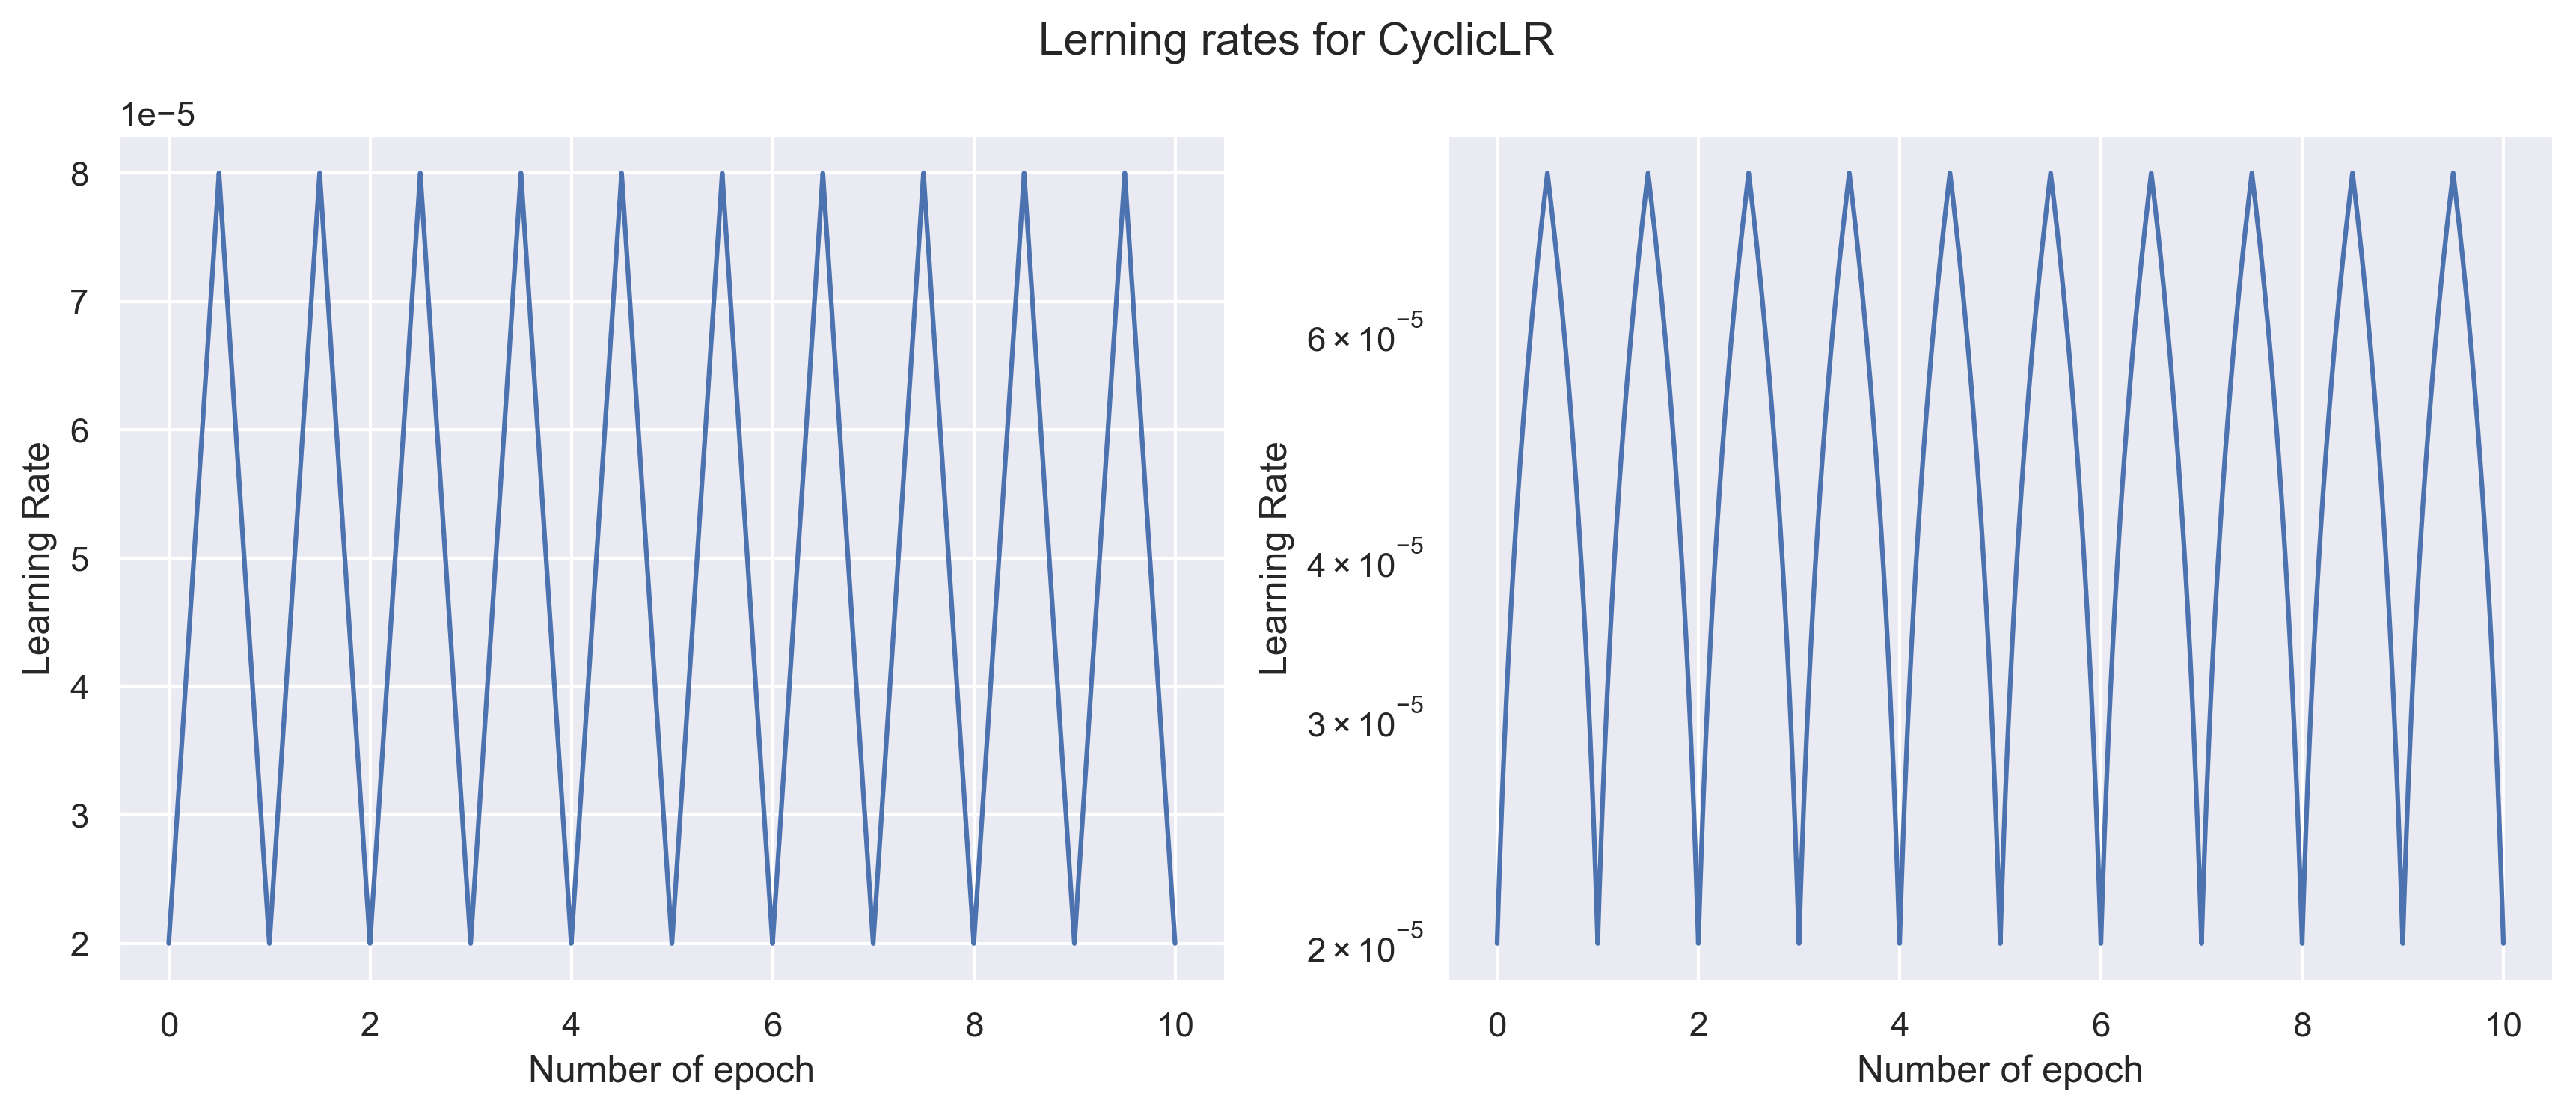

In [17]:
check_scheduler(CyclicLR(, .00008, 10, num_batches=8000, 
                base_lr=.00002, max_lr=.00008, step_size_up=4000)

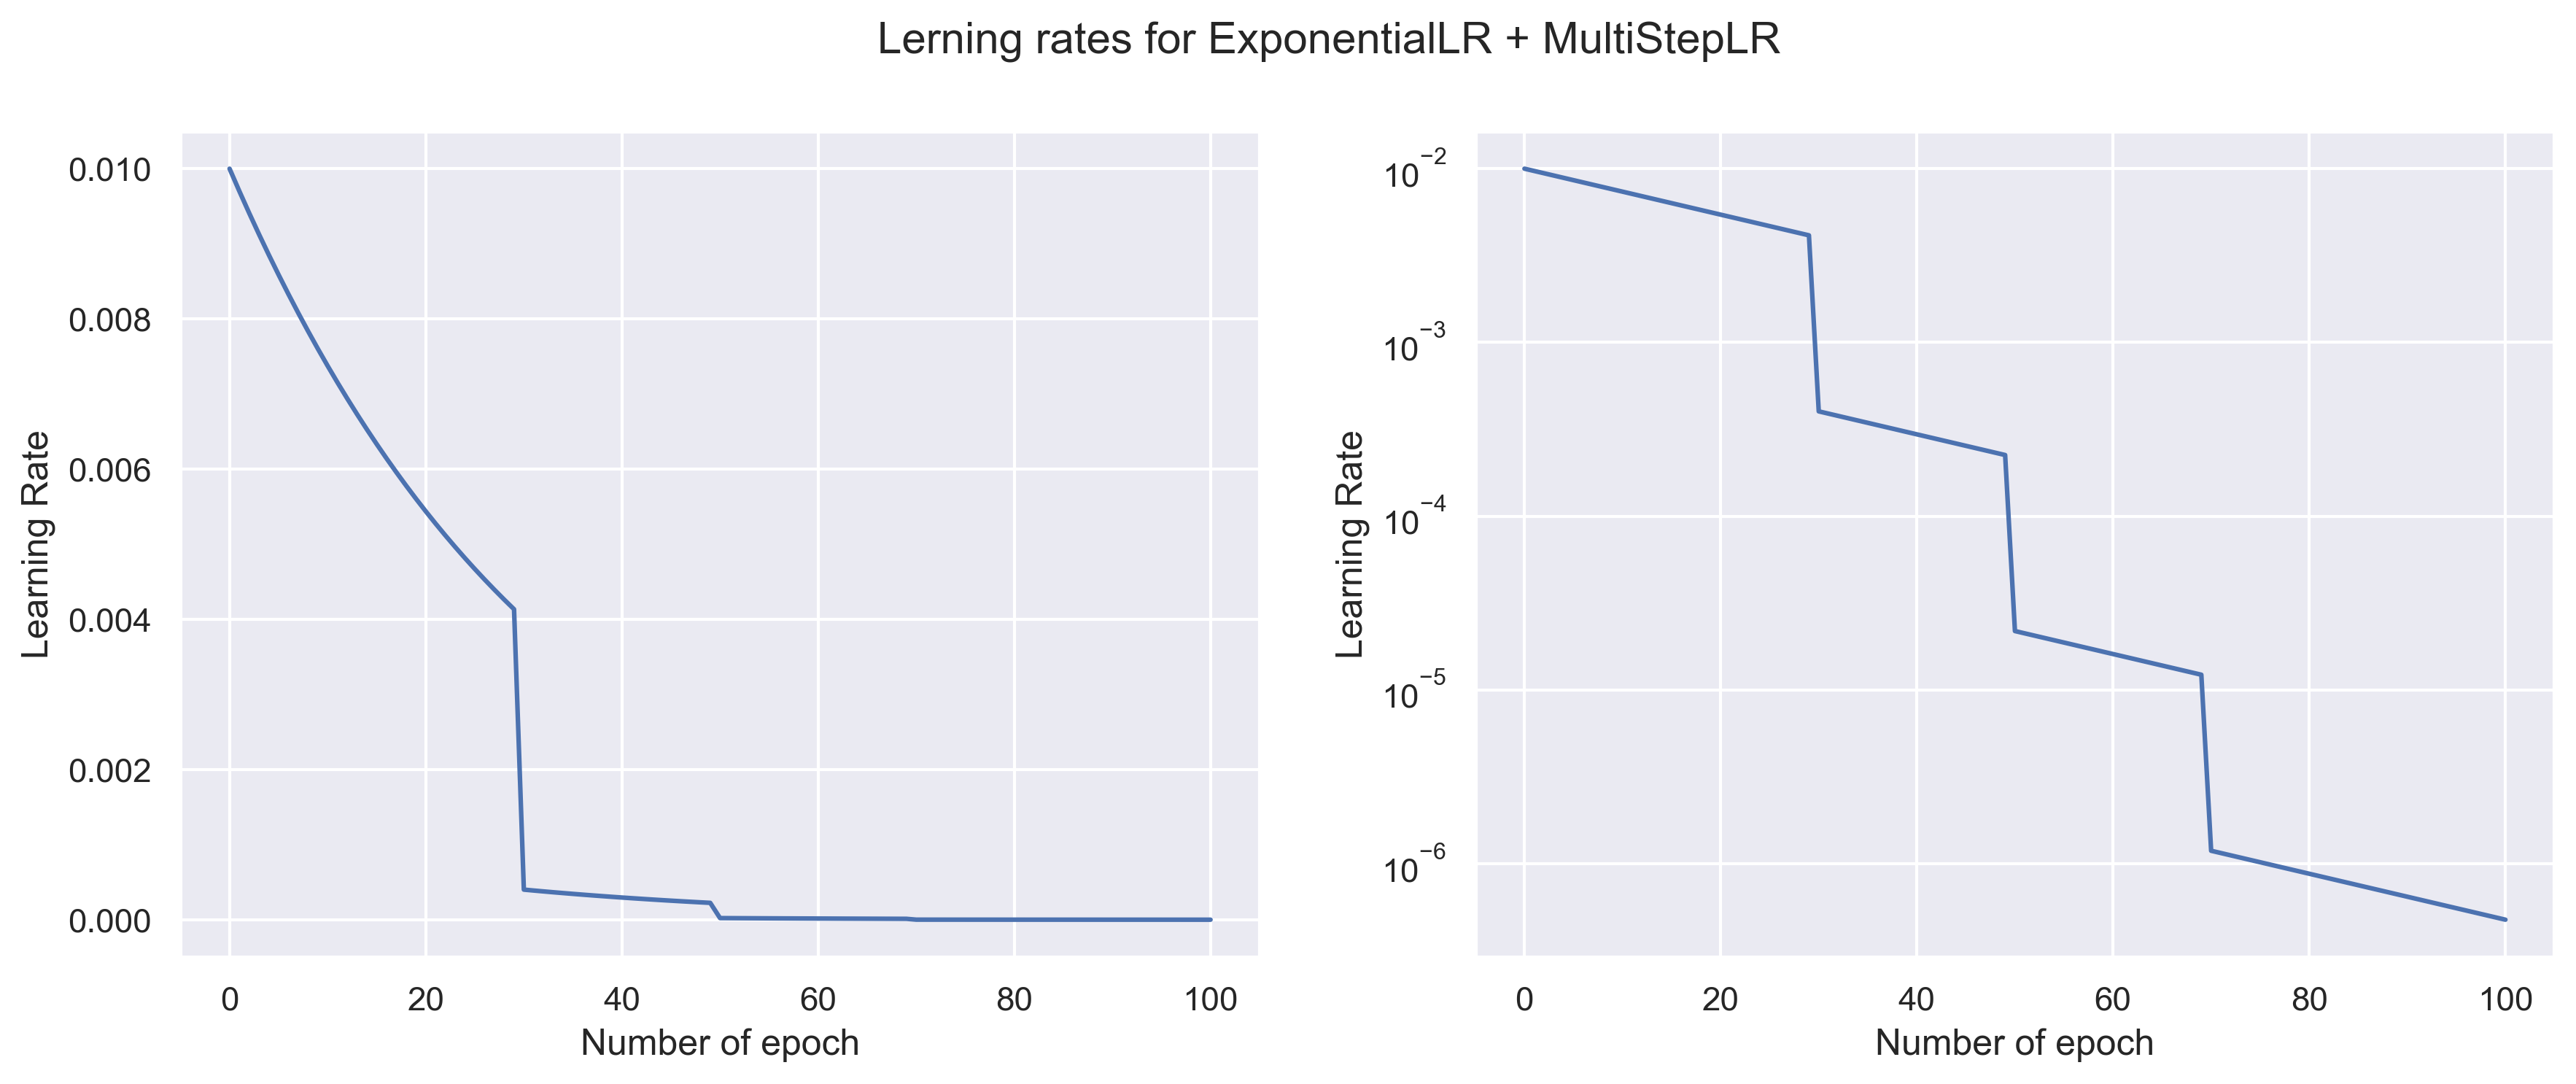

In [8]:
schedulers_params = [
{
    'name': ExponentialLR,
    'params': {'gamma': 0.97}
},    
{
    'name': MultiStepLR,
    'params': {'milestones': [30, 50, 70]}
},]

check_stack_schedulers(schedulers_params, 100)

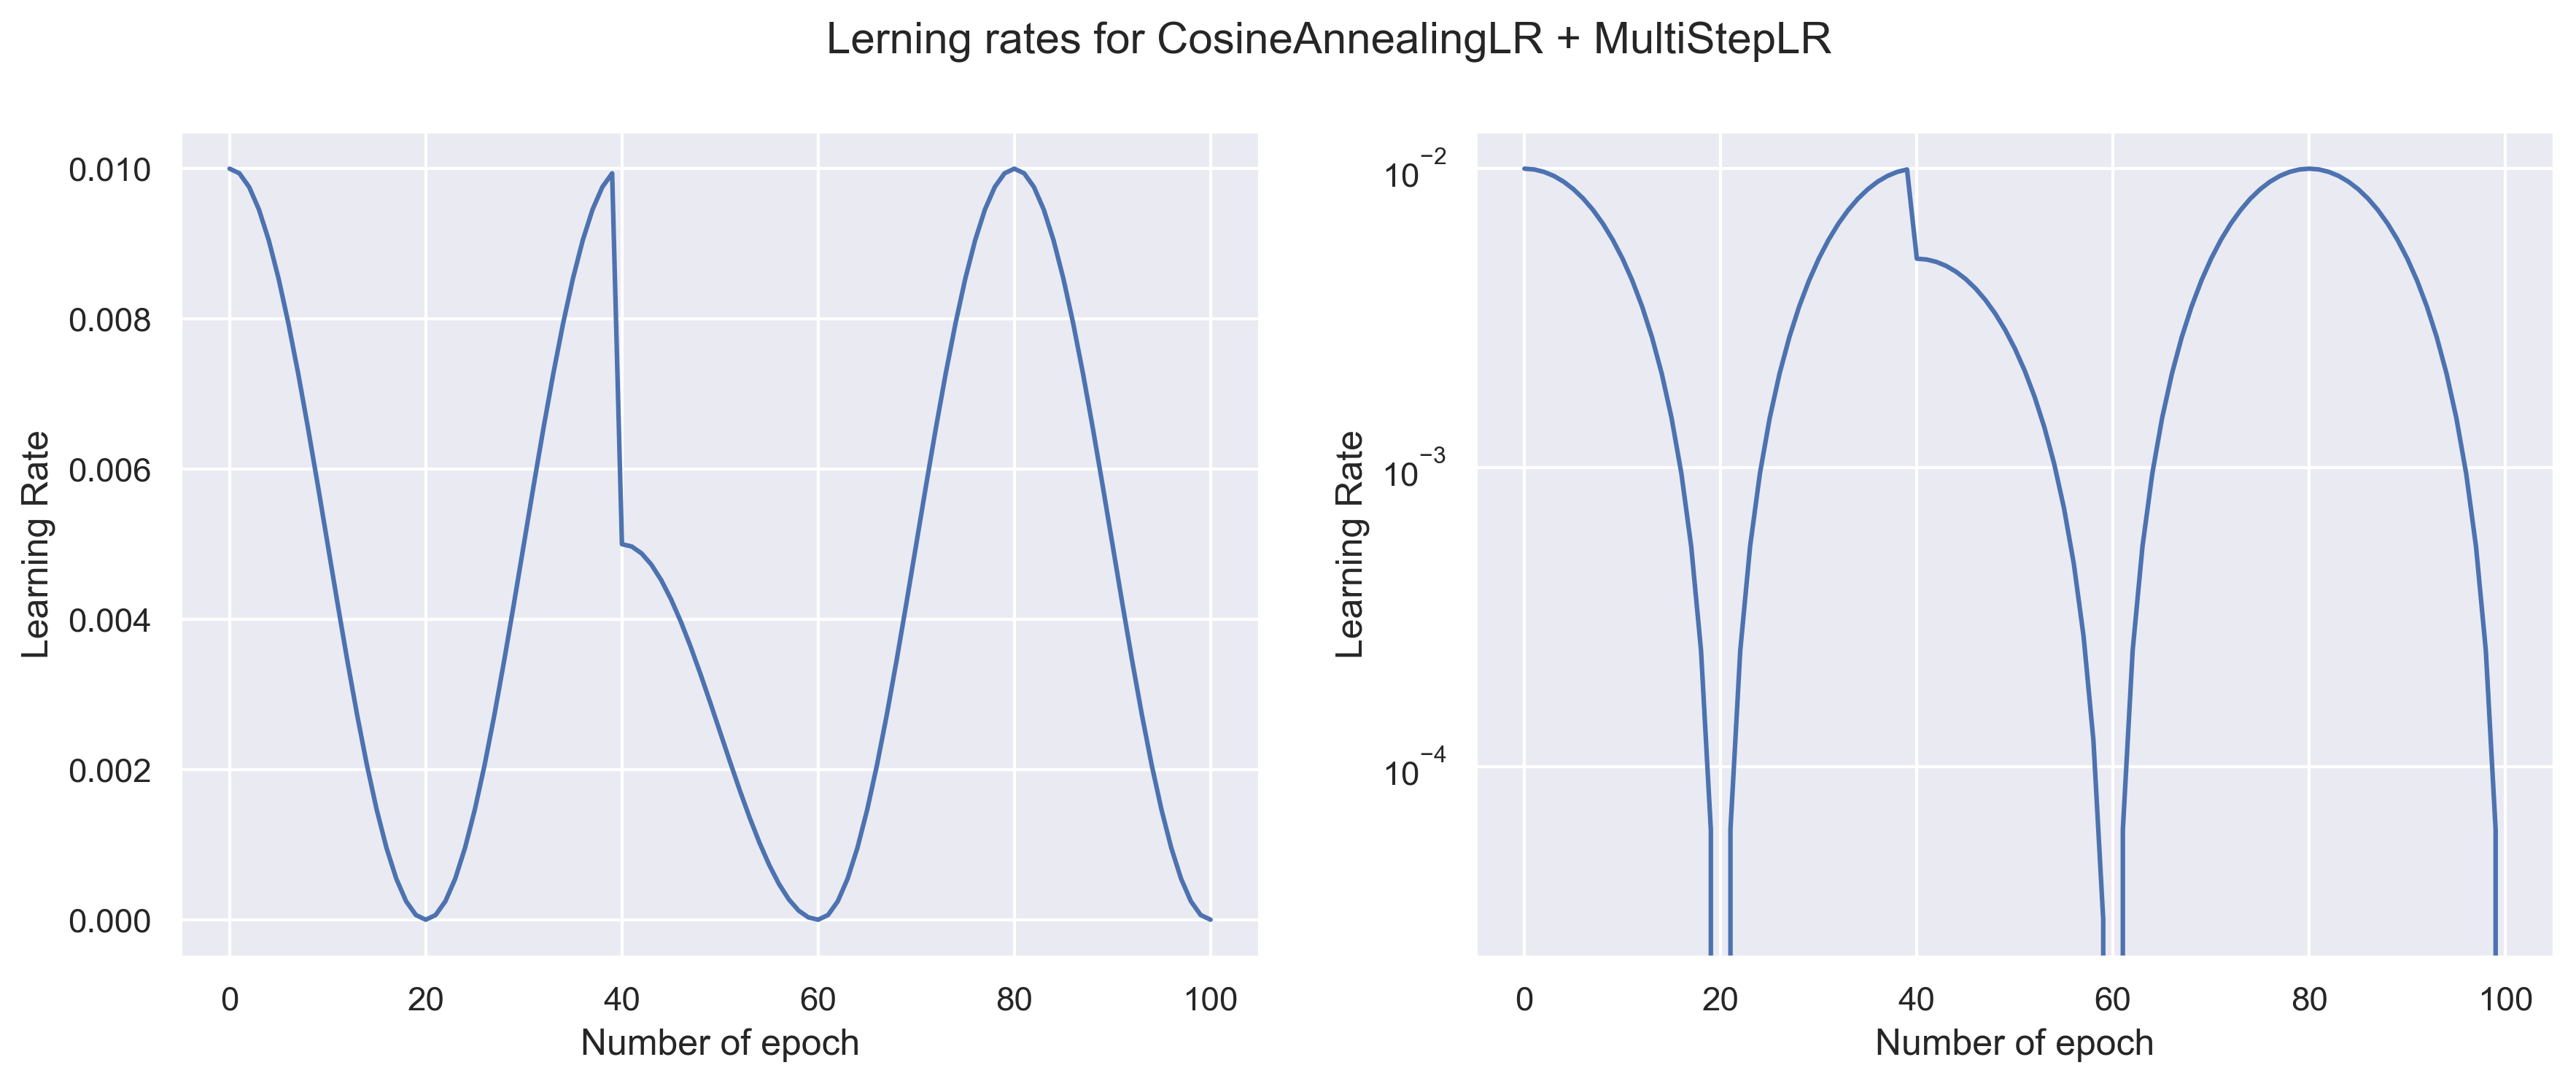

In [11]:
schedulers_params = [
{
    'name': CosineAnnealingLR,
    'params': {'T_max': 20}
},    
{
    'name': MultiStepLR,
    'params': dict(milestones=[20, 40, 60], gamma=0.5)
},]

check_stack_schedulers(schedulers_params, 100)

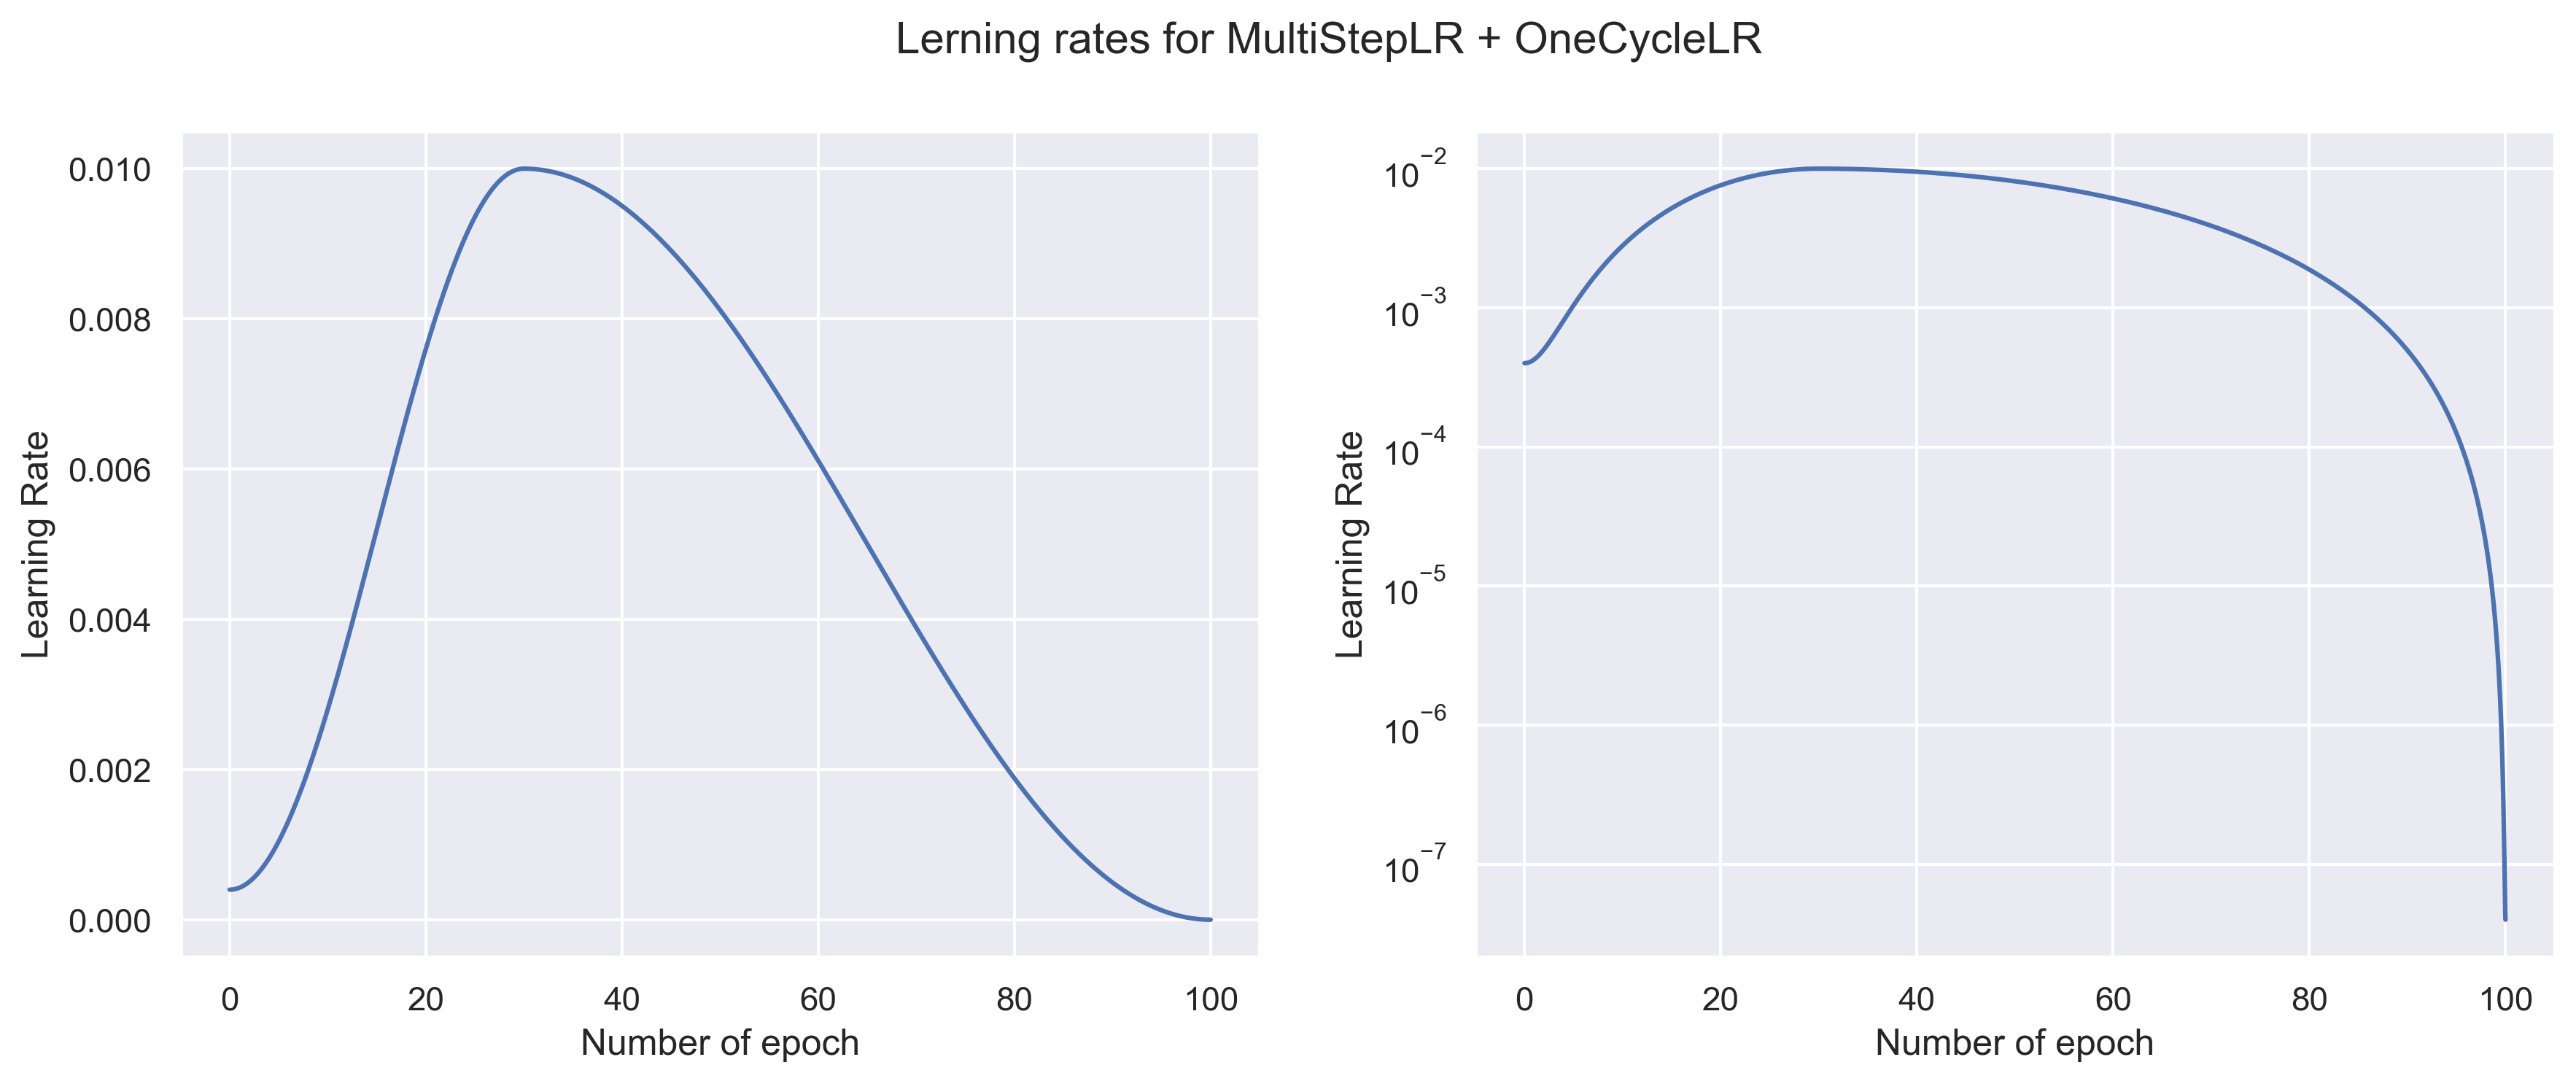

In [35]:
schedulers_params = [
{
    'name': MultiStepLR,
    'params': {'milestones': [30, 50, 70]}
},    
{
    'name': OneCycleLR,
    'params': {'max_lr': 1e-2,
               'epochs': 100,
               'steps_per_epoch': 1000,
               'anneal_strategy': 'cos'}
},
]

check_stack_schedulers(schedulers_params, 100)

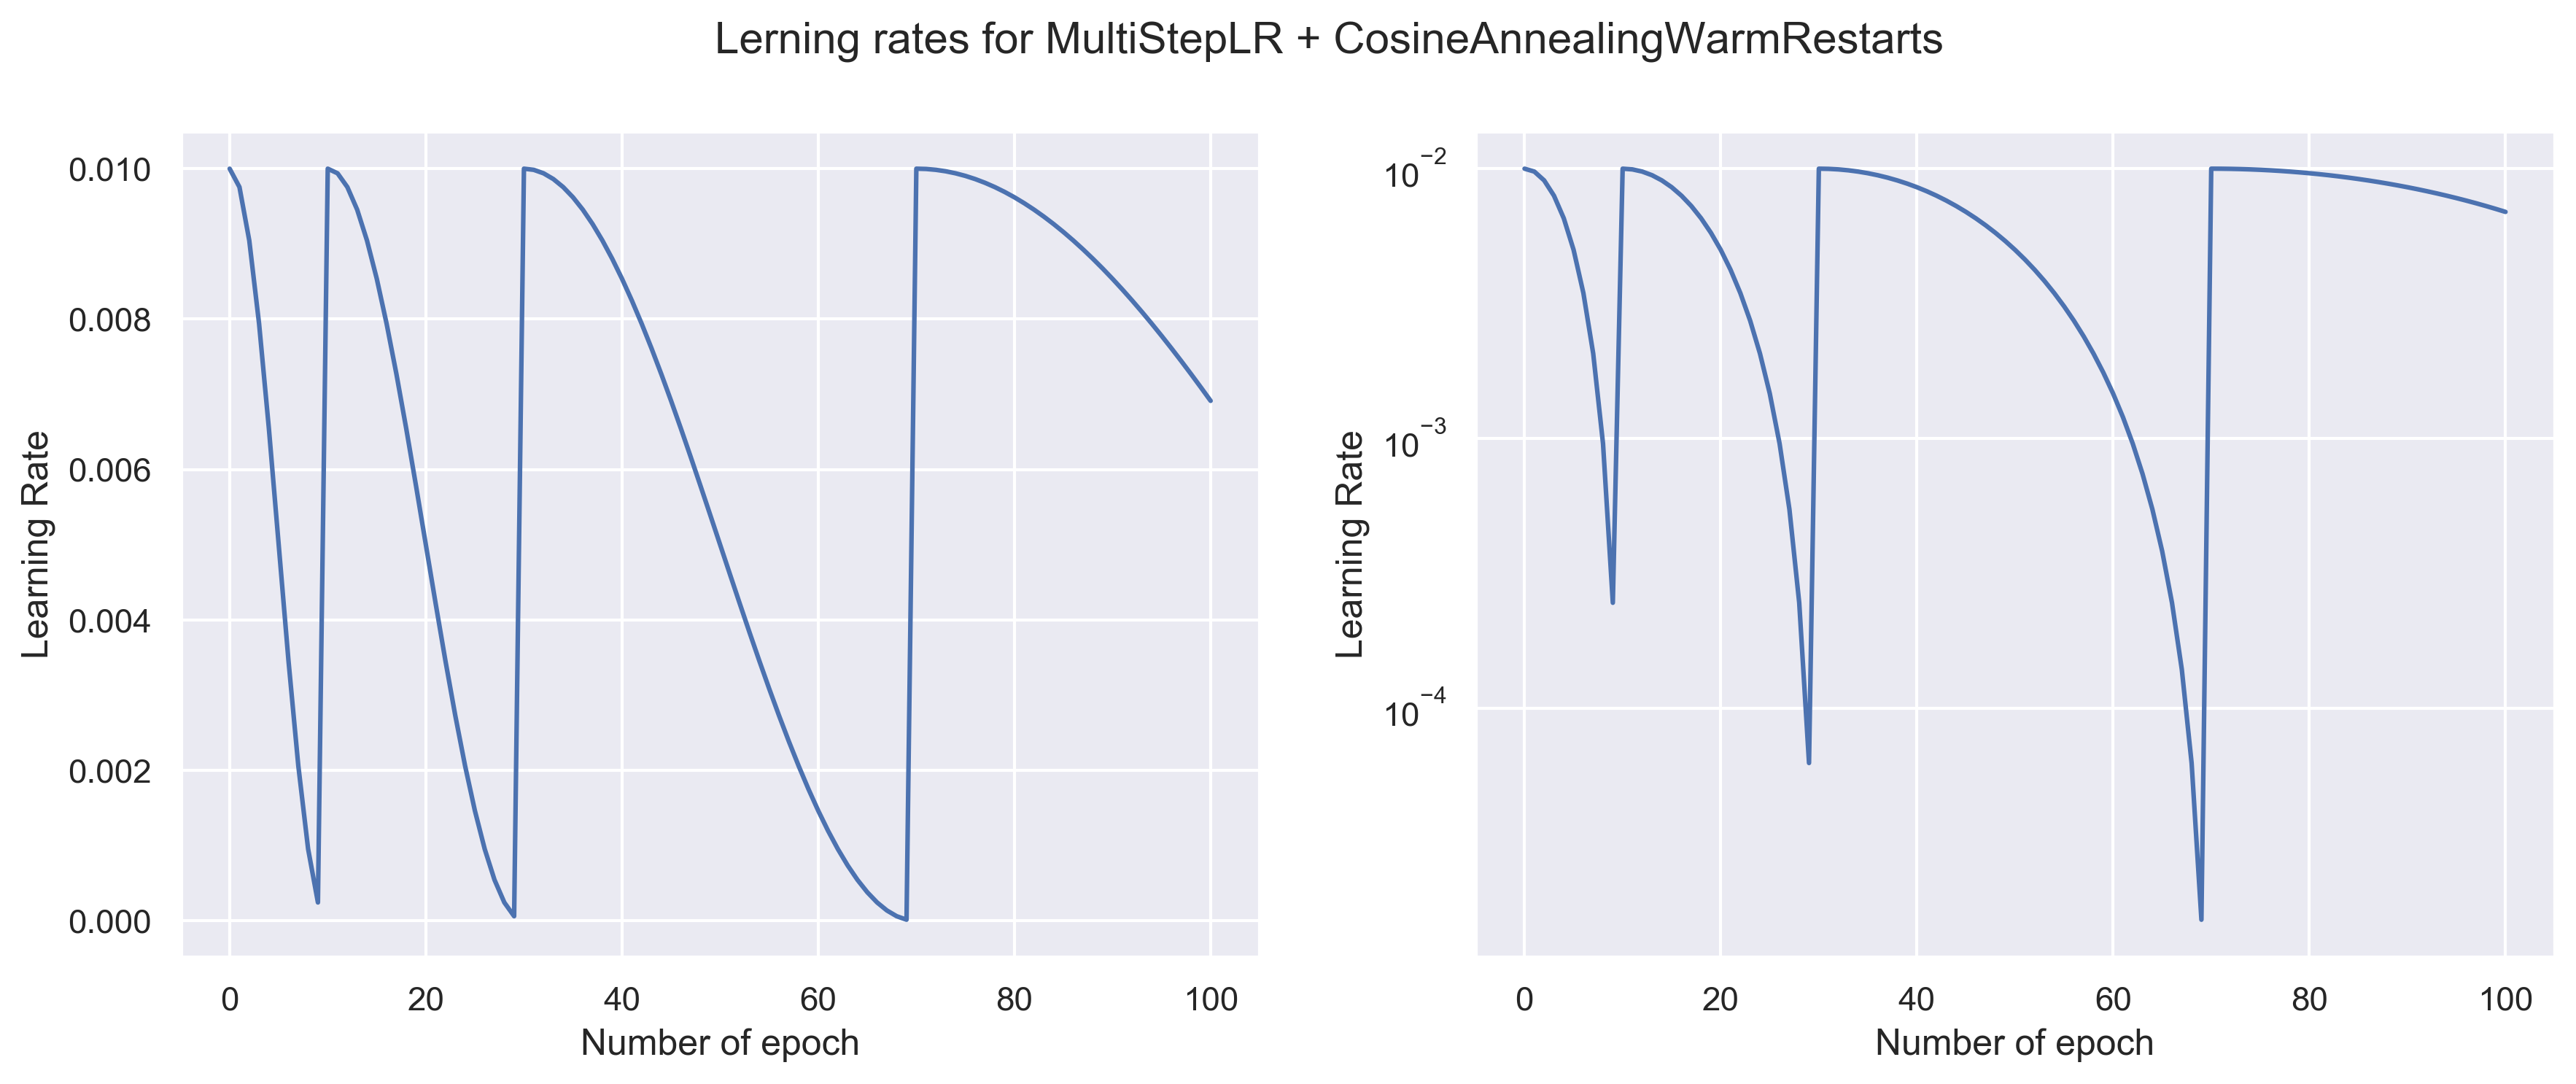

In [33]:
schedulers_params = [
{
    'name': MultiStepLR,
    'params': {'milestones': [20, 40, 60]}
},    
{
    'name': CosineAnnealingWarmRestarts,
    'params': {'T_0': 10,
               'T_mult': 2,
               'eta_min': 1e-6}
},
]

check_stack_schedulers(schedulers_params, 100)